# CARDIO CATCH DISEASES

 ## **Problem Definition:**

(Disclaimer: all information found here is _fictitious_) - CCD - Cardio Catch Diseases - is a company that offers services in **early diagnosis of cardiovascular diseases**. Currently a team of specialists is in charge of providing the diagnoses and the costs revolve around **RS1000 per diagnosys**. Customers are charged based on the diagnostic accuracy, ranging between **55% and 65%**. Each **5% increase in accuracy** levels above 50% costs **RS500 to the customer**. That results in fluctuating income for the company each month. Our job is to build a **cardiovascular disease classification model** that increases accuracy and precision of diagnoses that works with stable accuracy levels. 

### **_Business Problem Statement / Answers the CEO of the company is seeking:_**
- What are the values for precision and accuracy of the model?
- What is CCD's profit with this model?
- What is the confidence level of the model?

# 0.0 IMPORTS 

In [1]:
import os
import pickle
import datetime
import warnings

import numpy      as np
import pandas     as pd
import seaborn    as sns
import xgboost    as xgb

from boruta                   import BorutaPy
from tabulate                 import tabulate
from lightgbm                 import LGBMClassifier
from IPython.display          import Image
from IPython.core.display     import HTML
from sklearn.model_selection  import train_test_split, RandomizedSearchCV

from scipy                    import stats         as ss
from sklearn                  import preprocessing as pp, ensemble as en, neighbors as nh, metrics as m, \
                                     linear_model as lm, naive_bayes as nb, neural_network as nn, model_selection as ms
from matplotlib               import pyplot        as plt

## 0.1 Helper Functions

In [2]:
def cross_validation(num_folds, model_name, model, x_training, verbose = 0):
    kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle = True, random_state = 42 )
  
    prec_list = []
    rec_list = []
    acc_list = []
                
    i=1
                
    X = x_training.drop('cardio', axis = 1 )
    y = x_training['cardio']

    for train_cv,val_cv in kfold.split( X, y):
        
        if verbose == 1:
            print('Model: {} - Fold Number {}/{}'.format(model_name, i,num_folds))

        x_train_fold = X.iloc[ train_cv ]
        y_train_fold = y.iloc[ train_cv ]

        x_val_fold = X.iloc[ val_cv ]
        y_val_fold = y.iloc[ val_cv ]
        
        model_fit = model.fit( x_train_fold, y_train_fold )

        yhat_model = model_fit.predict( x_val_fold )
                    
        p = m.precision_score(y_val_fold, yhat_model)
        r = m.recall_score(y_val_fold, yhat_model)
        a = m.accuracy_score(y_val_fold, yhat_model)
              
        prec_list.append(p)
        rec_list.append(r)
        acc_list.append(a)
                
        i+=1
    
    cv_metrics = [np.mean(prec_list)]
    CV = pd.DataFrame(cv_metrics).T
    CV.columns = ['mean precision']
    CV.index = [model_name]
    CV['std precision'] = [np.std(prec_list)]
    CV['max precision'] = [np.max(prec_list)]
    CV['mean recall'] = [np.mean(rec_list)]
    CV['std recall'] = [np.std(rec_list)]
    CV['max recall'] = [np.max(rec_list)]
    CV['mean accuracy'] = [np.mean(acc_list)]
    CV['std accuracy'] = [np.std(acc_list)]
    CV['max accuracy'] = [np.max(acc_list)]
    CV['mean f1score'] = [2*np.mean(prec_list)*np.mean(rec_list)/(np.mean(prec_list)+np.mean(rec_list))]
    return CV

#machine learning models basic metrics
def ml_metrics(y_true, y_hat, model_name):
        acc = m.accuracy_score(y_true, y_hat)
        prec = m.precision_score(y_true, y_hat)
        rec = m.recall_score(y_true, y_hat)
        f1 = m.f1_score(y_true, y_hat)
        av_prec = m.average_precision_score(y_true, y_hat)
        roc = m.roc_auc_score(y_true, y_hat)
        #dict = {'Model': model_name, 'Precision': prec, 'Recall': rec, 'Accuracy': acc, 'Average Precision': av_prec, 'F1 Score': f1, 'ROC AUC': roc}
        #result = pd.DataFrame(dict)
        result = pd.DataFrame({'Model': model_name, 'Precision': prec, 'Recall': rec, 'Accuracy': acc, \
                               'Average Precision': av_prec, 'F1 Score': f1, 'ROC AUC': roc}, index = [0])
        return result

#Categorical EDA
def cat_eda(feature, response, data):
    aux = data[[feature, response]]
    aux['id'] = aux[feature]
    aux = aux[[feature, 'id', response]].groupby([feature, response]).count().reset_index()
    aux['%'] = aux['id'].apply( lambda x: x/aux['id'].sum()*100 )
    aux = aux.drop('id', axis = 1)
    return aux


#Numerical Data descriptive statistics
def desc_num (num_att):

    #measures of central tendency: mean and median
    #mean
    ct1 = num_att.apply( lambda x: np.mean(x) )
    #median
    ct2 = num_att.apply( lambda x: np.median(x) )

    #measures of spread: min, max, range and standard deviation
    #min
    d1 = num_att.apply( lambda x: np.min(x) )
    #max
    d2 = num_att.apply( lambda x: np.max(x) )
    #range
    d3 = num_att.apply( lambda x: np.max(x) - np.min(x) )
    #std
    d4 = num_att.apply( lambda x: np.std(x) )
    
    #measures of shape: skew and kurtosis
    #skew
    d5 = num_att.apply( lambda x: x.skew() )
    #kurtosis
    d6 = num_att.apply( lambda x: x.kurtosis() )

    num_df = pd.DataFrame( [ d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
    num_df.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
    return num_df

def cramers_v( cat_df):
    d = {}
   
    for i in range( len (cat_df.columns ) ):
        c = []
        for j in range( len (cat_df.columns ) ):
            c.append( cramer(cat_df[ cat_df.columns[i] ], cat_df[ cat_df.columns[j] ] ) )
        d[ cat_df.columns[i] ] = c
    m = pd.DataFrame( d )
    m = m.set_index( m.columns )
    sns.heatmap( m, annot = True)
    return m

def cramer( a1, a2 ):    
    cm = pd.crosstab( a1, a2 ).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    k, r = cm.shape
    phi = chi2 / n
    v = np.sqrt ( phi / (min (k-1, r-1) ) )
    phi_ap = max( 0, phi - (k-1) * (r-1) / (n-1) ) 
    k1 = k - ( ( k - 1)**2 ) / (n - 1)
    r1 = r - ( ( r - 1)**2 ) / (n - 1)
    v_corr = np.sqrt( (phi_ap) / min( k1-1, r1-1 ) )
    
    return v_corr

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [22, 11]
    plt.rcParams['font.size'] = 23
    
    display( HTML( '<style>.container { width: 90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
warnings.filterwarnings("ignore")

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_raw = pd.read_csv('data/cardio_train.csv', sep = ';')

# 1.0 STEP 01 - DATA DESCRIPTION

## 1.0.1 Column Description

Data description<br>
There are 3 types of input features:<br>

Objective: factual information; <br>
Examination: results of medical examination;<br>
Subjective: information given by the patient.<br>
Features:

Age | Objective Feature | age | int (days)<br>
Height | Objective Feature | height | int (cm) |<br>
Weight | Objective Feature | weight | float (kg) |<br>
Gender | Objective Feature | gender | categorical code |<br>
Systolic blood pressure | Examination Feature | ap_hi | int |<br>
Diastolic blood pressure | Examination Feature | ap_lo | int |<br>
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br>
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br>
Smoking | Subjective Feature | smoke | binary |<br>
Alcohol intake | Subjective Feature | alco | binary |<br>
Physical activity | Subjective Feature | active | binary |<br>
Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

Initial research: <br>

Cholerestol levels: normal: 125-200 mg/dl | above normal: 200-239 mg/dl | well above normal: > 240 mg/dl <br>
Glucose levels (fasting blood sugar test): normal: <100 mg/dl | above normal: 100-125 mg/dl | well above normal: > 125 mg/dl <br>
SBP levels: normal: up to 120 | elevated: 121-129 | hypertension stage I: 130-139 | hypertension stage II: >139 | hypertensive crisis: >179 |<br>
DBP levels: normal: up to 80 | elevated: <80 | hypertension stage I: 80-89 | hypertension stage II: >89 | hypertensive crisis: >119 |<br>

In [5]:
df1 = df_raw.copy()
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

## 1.1 Column Renaming

In [6]:
df1.columns = [ 'id', 'age', 'gender', 'height', 'weight', 'sbp', 'dbp', 'cholesterol', 'glucose', 'smoking', 'alcohol', 'active', 'cardio']

## 1.2 Data Dimensions

In [7]:
print( 'Rows count: {}'.format( df_raw.shape[0] ) )
print( 'Columns count: {}'.format( df_raw.shape[1] ) )

Rows count: 70000
Columns count: 13


## 1.3 Data Types

In [8]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
sbp              int64
dbp              int64
cholesterol      int64
glucose          int64
smoking          int64
alcohol          int64
active           int64
cardio           int64
dtype: object

## 1.4 NA Checking

In [9]:
df1.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
sbp            0
dbp            0
cholesterol    0
glucose        0
smoking        0
alcohol        0
active         0
cardio         0
dtype: int64

No missing data.

## 1.5 Descriptive Statistics

In [10]:
#converting numerical values to descriptive text

df1['gender'] = df1['gender'].apply(lambda x: 'Male' if x == 1 else 'Female')
df1['cholesterol'] = df1['cholesterol'].apply(lambda x: 'Normal' if x == 1 else 'Above normal' if x== 2 else 'Well above normal')
df1['glucose'] = df1['glucose'].apply(lambda x: 'Normal' if x == 1 else 'Above normal' if x== 2 else 'Well above normal')
df1['smoking'] = df1['smoking'].apply(lambda x: 'Yes' if x == 1 else 'No')
df1['alcohol'] = df1['alcohol'].apply(lambda x: 'Yes' if x == 1 else 'No')
df1['active'] = df1['active'].apply(lambda x: 'Yes' if x == 1 else 'No')
df1['cardio_cat'] = df1['cardio'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [11]:
cat_features = ['gender', 'cholesterol', 'glucose', 'smoking', 'alcohol', 'active', 'cardio', 'cardio_cat'] 
num_features = ['age', 'height', 'weight', 'sbp', 'dbp']

In [12]:
num_att = df1[num_features]
cat_att = df1[cat_features]

### 1.5.1 Numerical Data

In [13]:
num_df = desc_num(num_att)
num_df

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,age,10798.0,23713.0,12915.0,19468.865814,19703.0,2467.234044,-0.307055,-0.823447
1,height,55.0,250.0,195.0,164.359229,165.0,8.210068,-0.642187,7.943653
2,weight,10.0,200.0,190.0,74.205690,72.0,14.395654,1.012070,2.586825
3,sbp,-150.0,16020.0,16170.0,128.817286,120.0,154.010319,85.296214,7580.074738
4,dbp,-70.0,11000.0,11070.0,96.630414,80.0,188.471184,32.114083,1425.914585


Clearly inconsistent values on SBP and DBP. Most likely due to mistyping. Age should be shown in years. Lower weight values seem too low.

In [14]:
#checking weight
df1[ df1['weight'] < 30]

,id,age,gender,height,weight,sbp,dbp,cholesterol,glucose,smoking,alcohol,active,cardio,cardio_cat
26806,38312,23284,Male,157,23.0,110,80,Normal,Normal,No,No,Yes,0,No
29488,42156,20408,Female,177,22.0,120,80,Normal,Normal,Yes,Yes,Yes,0,No
33817,48318,21582,Female,178,11.0,130,90,Normal,Normal,No,No,Yes,1,Yes
34276,48976,14664,Female,128,28.0,120,80,Normal,Normal,No,No,Yes,0,No
57858,82567,18804,Female,165,10.0,180,1100,Above normal,Above normal,No,No,Yes,1,Yes
60188,85931,21855,Male,162,21.0,120,80,Above normal,Normal,No,No,Yes,1,Yes
60699,86650,18875,Male,171,29.0,110,70,Above normal,Normal,No,No,Yes,1,Yes


Drop values under 30kg.

In [15]:
#checking SBP
df1[ df1['sbp'] < 0]

,id,age,gender,height,weight,sbp,dbp,cholesterol,glucose,smoking,alcohol,active,cardio,cardio_cat
4607,6525,15281,Male,165,78.0,-100,80,Above normal,Normal,No,No,Yes,0,No
16021,22881,22108,Female,161,90.0,-115,70,Normal,Normal,No,No,Yes,0,No
20536,29313,15581,Male,153,54.0,-100,70,Normal,Normal,No,No,Yes,0,No
23988,34295,18301,Male,162,74.0,-140,90,Normal,Normal,No,No,Yes,1,Yes
25240,36025,14711,Female,168,50.0,-120,80,Above normal,Normal,No,No,No,1,Yes
35040,50055,23325,Female,168,59.0,-150,80,Normal,Normal,No,No,Yes,1,Yes
46627,66571,23646,Female,160,59.0,-120,80,Normal,Normal,No,No,No,0,No


In [16]:
#checking SBP
df1[ df1['sbp'] > 600]

,id,age,gender,height,weight,sbp,dbp,cholesterol,glucose,smoking,alcohol,active,cardio,cardio_cat
1876,2654,15116,Male,160,60.0,902,60,Normal,Normal,No,No,Yes,0,No
2014,2845,22712,Female,167,59.0,906,0,Normal,Normal,No,No,Yes,0,No
4817,6822,14425,Male,168,63.0,909,60,Above normal,Normal,No,No,Yes,0,No
7763,11089,21032,Male,175,80.0,11500,90,Normal,Normal,No,No,Yes,1,Yes
8915,12710,18870,Male,164,75.0,1420,80,Above normal,Normal,No,No,Yes,1,Yes
9557,13616,22659,Male,155,87.0,701,110,Normal,Normal,No,No,Yes,1,Yes
13895,19827,15996,Male,168,72.0,1500,80,Normal,Normal,No,No,Yes,1,Yes
17713,25314,22398,Female,163,50.0,907,70,Well above normal,Well above normal,No,No,Yes,1,Yes
23867,34120,16131,Male,161,92.0,906,0,Above normal,Normal,No,No,Yes,1,Yes
25464,36339,15835,Female,169,75.0,14020,80,Above normal,Normal,No,No,Yes,1,Yes


Convert negative values to positive. Drop zeros. Higher values: Assume mistyping. 600 < sbp < 5000: divide by 10. 5000 and above: divide by 100.

In [17]:
#checking DBP
df1[ df1['dbp'] < 0].count()

id             1
age            1
gender         1
height         1
weight         1
sbp            1
dbp            1
cholesterol    1
glucose        1
smoking        1
alcohol        1
active         1
cardio         1
cardio_cat     1
dtype: int64

One negative value. Drop zeros. Higher values: Assume mistyping. 2000 < sbp < 5000: divide by 10. 5000 and above: divide by 100.

In [18]:
#converting age from days to years 
df1['age_years'] = df1['age'].apply( lambda x: round(x/365,1) )

#fixing sbp
df1['sbp'] = df1['sbp'].apply( lambda x: x if x < 600 else x/10 if ((x>=600) & (x<5000)) else x/100)
df1['sbp'] = df1['sbp'].apply( lambda x: round( np.abs(x),0) )
df1['sbp'] = df1['sbp'].apply( lambda x: x if x > 20 else x*10 )
sbp_zeros = df1[ df1['sbp'] == 0 ].index
df1 = df1.drop(sbp_zeros)
                              
#fixing dbp
df1['dbp'] = df1['dbp'].apply( lambda x: x if x < 200 else x/10 if ((x>=200) & (x<5000)) else x/100)
df1['dbp'] = df1['dbp'].apply( lambda x: round( np.abs(x),0) )
df1['dbp'] = df1['dbp'].apply( lambda x: x if x > 20 else x*10 )
dbp_zeros = df1[ df1['dbp'] == 0 ].index
df1 = df1.drop(dbp_zeros)

#swapping values when dbp > sbp:
swap_index = df1[ df1['sbp'] < df1['dbp']].index
aux1 = df1.loc[swap_index]['sbp'].values
df1['sbp'][swap_index] = df1['dbp'][swap_index].values
df1['dbp'][swap_index] = aux1

#dropping lower weight values
low_weight_index = df1[ df1['weight'] < 30].index
df1 = df1.drop(low_weight_index)

In [19]:
num_features = ['age_years', 'height', 'weight', 'sbp', 'dbp']
num_att = df1[num_features]
num_df = desc_num(num_att)
num_df

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,age_years,29.6,65.0,35.4,53.339524,54.0,6.759162,-0.307121,-0.823371
1,height,55.0,250.0,195.0,164.359387,165.0,8.209025,-0.641690,7.947345
2,weight,30.0,200.0,170.0,74.212932,72.0,14.385704,1.018950,2.579875
3,sbp,60.0,401.0,341.0,127.091051,120.0,17.111232,1.006016,2.723884
4,dbp,10.0,182.0,172.0,81.590136,80.0,9.786218,0.439485,2.510704


Still some odd numbers, but skew values for blood pressure measurements are already much better.

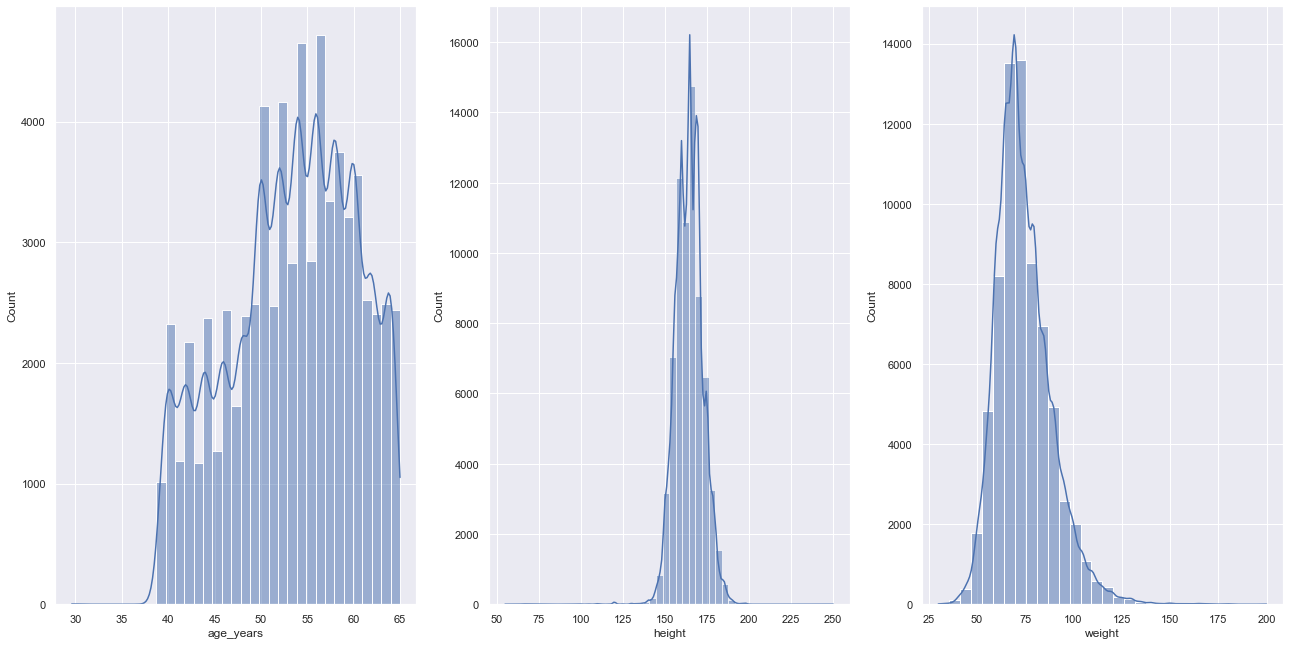

In [20]:
#age
plt.subplot(1, 3, 1)
sns.histplot( df1['age_years'], bins = 35, kde = True);

#height
plt.subplot(1, 3, 2)
sns.histplot( df1['height'], bins = 50, kde = True);

#weight
plt.subplot(1, 3, 3)
sns.histplot( df1['weight'], bins = 30, kde = True);

- Age: Data seems pretty consistent. No visible outliers.

- Height: Close to normally distributed. One row with the highest value is most likely an outlier and will be dropped. Lower values: after verifying lists of the shortest people in the world, values under 90cm will also be dropped.

- Weight: Close to normally distributed. Upper values are not too extreme to be dropped.

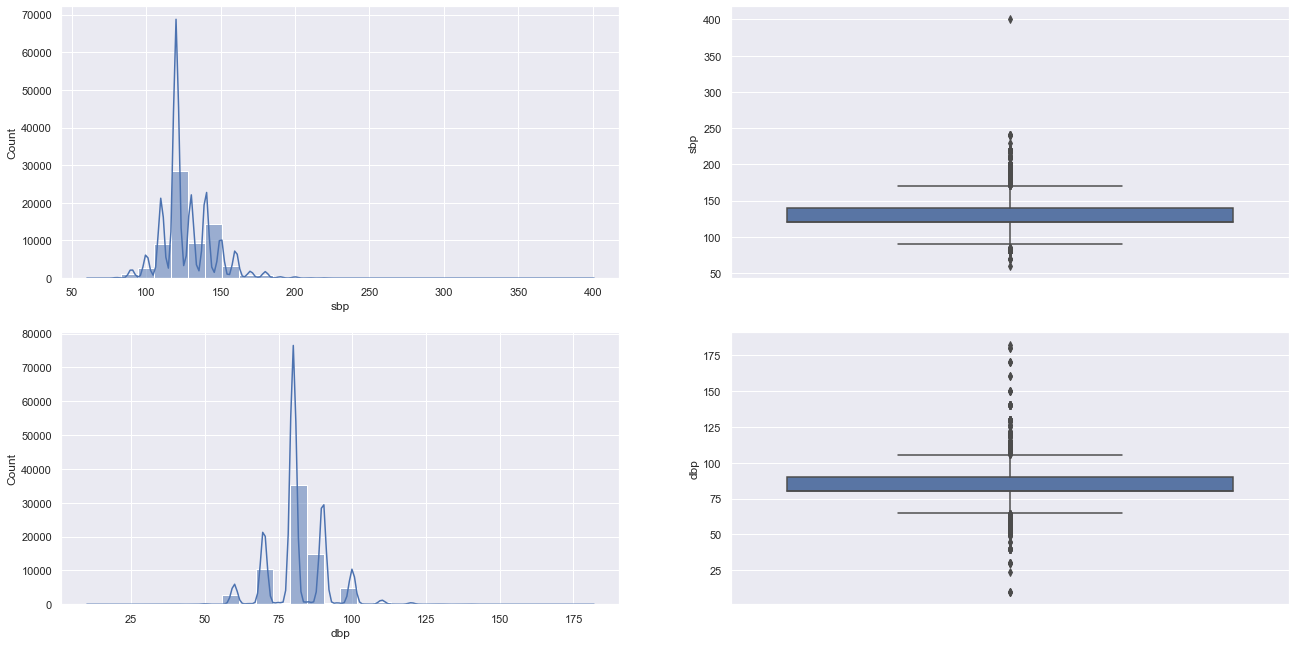

In [21]:
#blood pressure
plt.subplot(2, 2, 1)
sns.histplot( df1['sbp'], bins = 30, kde = True);

plt.subplot(2, 2, 2)
sns.boxplot( y = 'sbp', data = df1 );

plt.subplot(2, 2, 3)
sns.histplot( df1['dbp'], bins = 30, kde = True);

plt.subplot(2, 2, 4)
sns.boxplot( y = 'dbp', data = df1 );

In [22]:
df1[ df1['sbp'] > 300]

,id,age,gender,height,weight,sbp,dbp,cholesterol,glucose,smoking,alcohol,active,cardio,cardio_cat,age_years
40831,58349,19806,Male,162,67.0,401.0,80.0,Normal,Well above normal,No,No,Yes,1,Yes,54.3


Still some values are way too off. Dropping sbp > 300.

### 1.5.2 Categorical Data

In [23]:
cat_att.apply( lambda x: x.unique().shape[0] )

gender         2
cholesterol    3
glucose        3
smoking        2
alcohol        2
active         2
cardio         2
cardio_cat     2
dtype: int64

In [24]:
cat_att.head()

,gender,cholesterol,glucose,smoking,alcohol,active,cardio,cardio_cat
0,Female,Normal,Normal,No,No,Yes,0,No
1,Male,Well above normal,Normal,No,No,Yes,1,Yes
2,Male,Well above normal,Normal,No,No,No,1,Yes
3,Female,Normal,Normal,No,No,Yes,1,Yes
4,Male,Normal,Normal,No,No,No,0,No


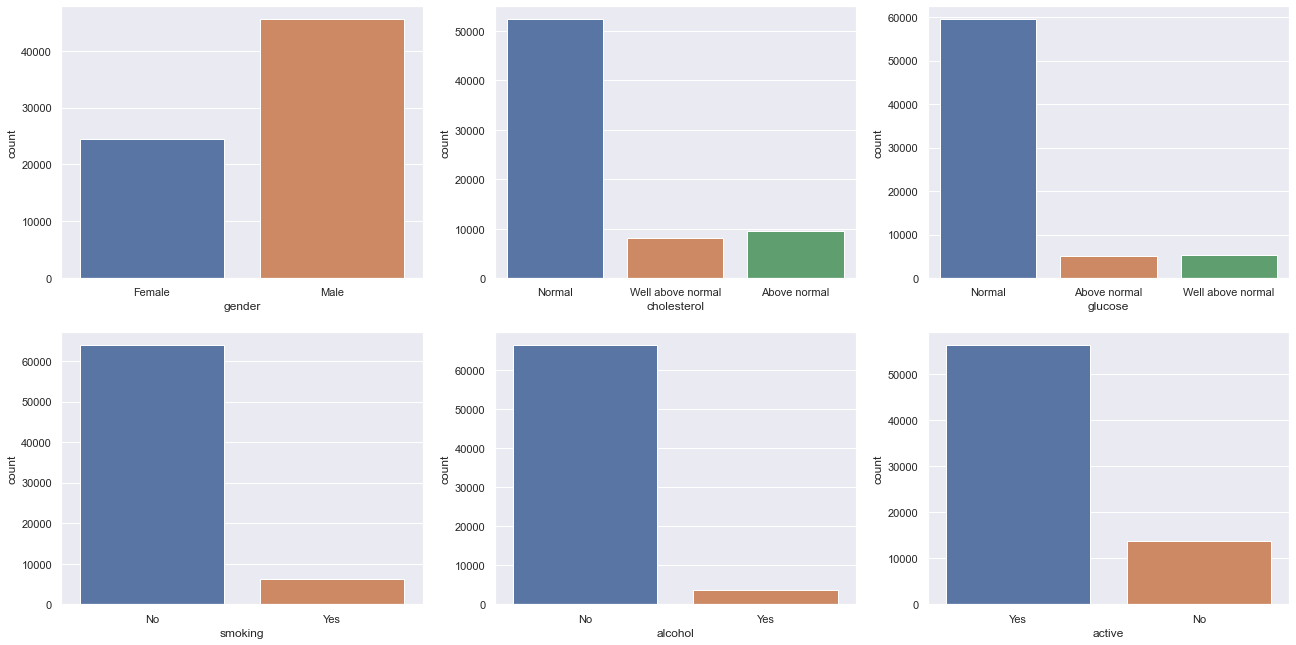

In [25]:
aux1 = cat_att.copy()

# gender
plt.subplot( 2, 3, 1 )
sns.countplot(aux1['gender']);

# cholesterol
plt.subplot( 2, 3, 2 )
sns.countplot(aux1['cholesterol']);

# glucose
plt.subplot( 2, 3, 3 )
sns.countplot(aux1['glucose']);

# smoking
plt.subplot( 2, 3, 4 )
sns.countplot(aux1['smoking']);

# alcohol
plt.subplot( 2, 3, 5 )
sns.countplot(aux1['alcohol']);

# active
plt.subplot( 2, 3, 6 )
sns.countplot(aux1['active']);

<AxesSubplot:xlabel='cardio', ylabel='count'>

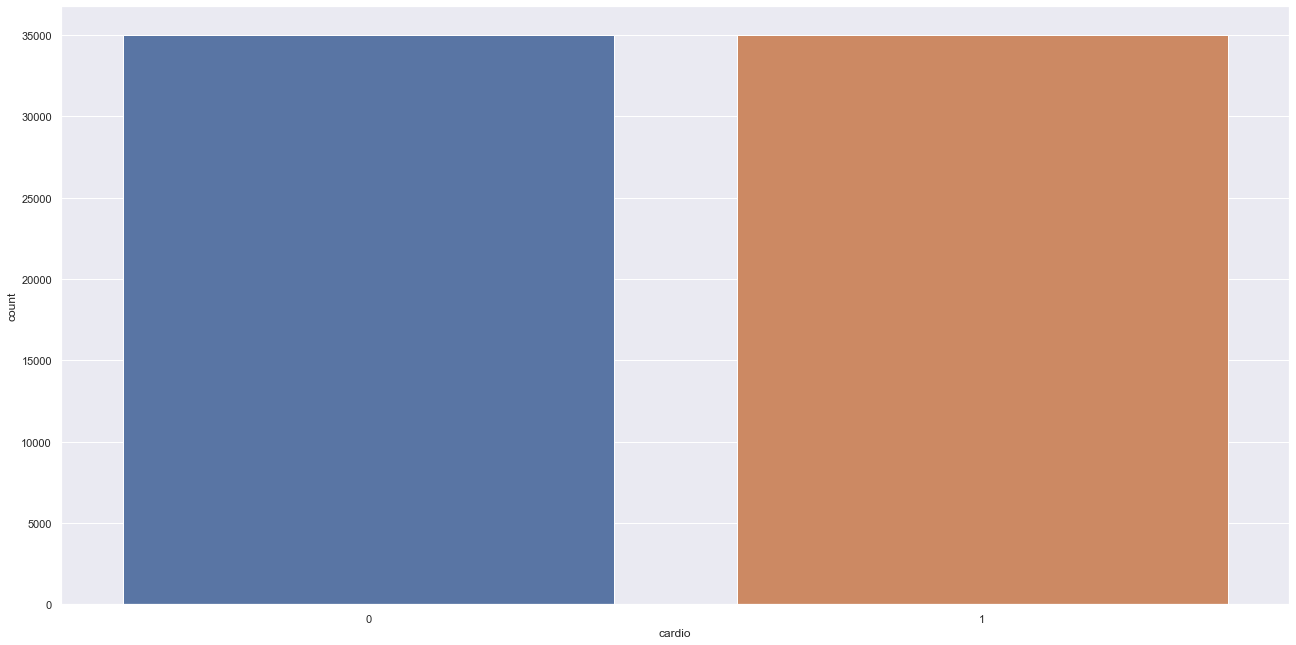

In [26]:
sns.countplot(aux1['cardio'])

### 1.5.3 Initial insights:


- Age: Data seems pretty consistent. No visible outliers;
- Height: Close to normally distributed. One row with the highest value is most likely an outlier and will be dropped. Lower values: drop values based on body mass index values;
- Weight: Close to normally distributed. Drop values based on body mass index values;
- Blood pressure values are within a pretty wide range;
- About half the samples show cardiac issues, even though we have more men than women. Are women more likely to suffer from cardiovascular diseases?;
- Most people seem to be healthy. There isn't a single feature that stands out as a common health problem.

# 2.0 STEP 02 - FEATURE ENGINEERING

In [27]:
df2 = df1.copy()

In [28]:
df2.head()

,id,age,gender,height,weight,sbp,dbp,cholesterol,glucose,smoking,alcohol,active,cardio,cardio_cat,age_years
0,0,18393,Female,168,62.0,110.0,80.0,Normal,Normal,No,No,Yes,0,No,50.4
1,1,20228,Male,156,85.0,140.0,90.0,Well above normal,Normal,No,No,Yes,1,Yes,55.4
2,2,18857,Male,165,64.0,130.0,70.0,Well above normal,Normal,No,No,No,1,Yes,51.7
3,3,17623,Female,169,82.0,150.0,100.0,Normal,Normal,No,No,Yes,1,Yes,48.3
4,4,17474,Male,156,56.0,100.0,60.0,Normal,Normal,No,No,No,0,No,47.9


## 2.1 Hypotheses Mind Map

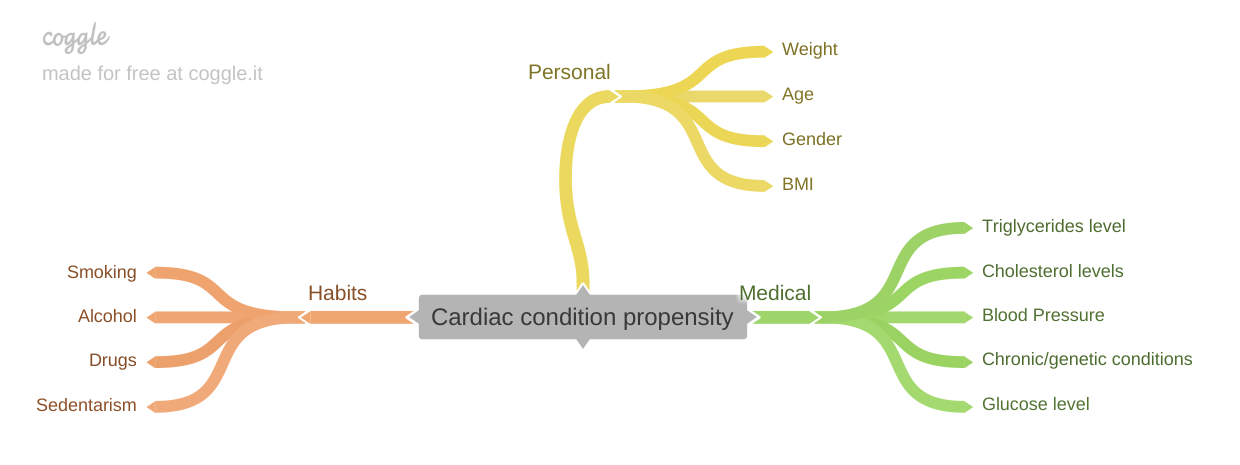

In [29]:
Image('image/Hypotheses mind map.png')

## 2.2 Hypotheses Creation

### 2.2.1 Personal Hypotheses

H1 - Female customers are more likely to have cardiovascular diseases. <br>
H2 - Customers who are 55 or older are more likely to have cardiovascular diseases. <br>
H3 - Customers with body mass index above 35 are more likely to have cardiovascular diseases. <br>

### 2.2.2 Medical Hypotheses

H4 - Customers whose systolic blood pressure levels are higher than 130 are more likely to have cardiovascular diseases. <br>
H5 - Customers whose diastolic blood pressure levels are higher than 80 are more likely to have cardiovascular diseases. <br>
H6 - Customers whose cholesterol levels are well above normal are more likely to have cardiovascular diseases. <br>
H7 - Customers whose glucose levels are well above normal are more likely to have cardiovascular diseases. <br>
H8 - Customers whose triglycerides levels are well above normal are more likely to have cardiovascular diseases. <br>
H9 - Customers with other genetic or chronic conditions are more likely to have cardiovascular diseases.

### 2.2.3 Habits Hypotheses

H10 - Smoker customers are more likely to have cardiovascular diseases. <br>
H11 - Customers who drink alcohol regularly are more likely to have cardiovascular diseases. <br>
H12 - Sedentary customers are more likely to have cardiovascular diseases. <br>
H13 - Illicit drugs users are more likely to have cardiovascular diseases.

## 2.3 Final Hypothesis List

H1 - Female customers are more likely to have cardiovascular diseases. <br>
H2 - Customers who are 55 or older are more likely to have cardiovascular diseases. <br>
H3 - Customers with body mass index above 35 are more likely to have cardiovascular diseases. <br>
H4 - Customers whose systolic blood pressure levels are higher than 130 are more likely to have cardiovascular diseases. <br>
H5 - Customers whose diastolic blood pressure levels are higher than 80 are more likely to have cardiovascular diseases. <br>
H6 - Customers whose cholesterol levels are well above normal are more likely to have cardiovascular diseases. <br>
H7 - Customers whose glucose levels are well above normal are more likely to have cardiovascular diseases. <br>
H8 - Smoker customers are more likely to have cardiovascular diseases. <br>
H9 - Customers who drink alcohol regularly are more likely to have cardiovascular diseases. <br>
H10 - Sedentary customers are more likely to have cardiovascular diseases. <br>

## 2.4 Feature Engineering

In [30]:
#BMI   
df2['bmi'] = df2.apply(lambda x: round(x['weight']/(x['height']/100)**2, 2), axis = 1)

In [31]:
df2.head()

,id,age,gender,height,weight,sbp,dbp,cholesterol,glucose,smoking,alcohol,active,cardio,cardio_cat,age_years,bmi
0,0,18393,Female,168,62.0,110.0,80.0,Normal,Normal,No,No,Yes,0,No,50.4,21.97
1,1,20228,Male,156,85.0,140.0,90.0,Well above normal,Normal,No,No,Yes,1,Yes,55.4,34.93
2,2,18857,Male,165,64.0,130.0,70.0,Well above normal,Normal,No,No,No,1,Yes,51.7,23.51
3,3,17623,Female,169,82.0,150.0,100.0,Normal,Normal,No,No,Yes,1,Yes,48.3,28.71
4,4,17474,Male,156,56.0,100.0,60.0,Normal,Normal,No,No,No,0,No,47.9,23.01


# 3.0 STEP 03 - FEATURE FILTERING

In [32]:
df3 = df2.copy()

## 3.1 Row Selection

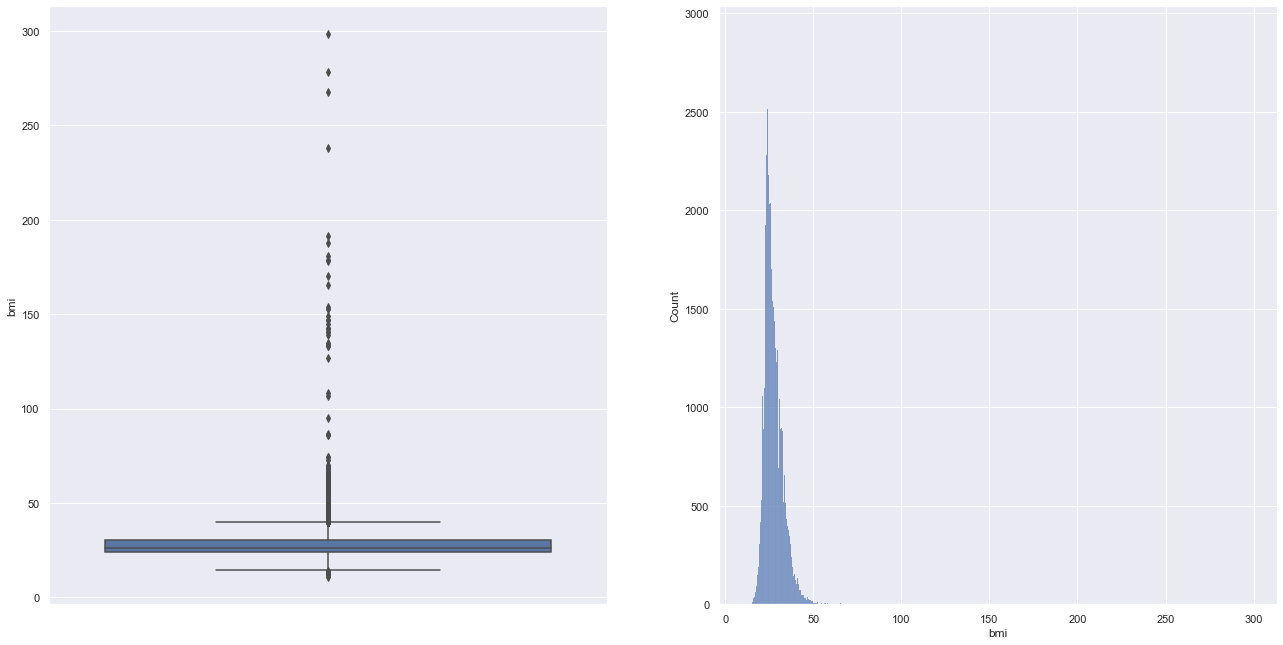

In [33]:
plt.subplot(1,2,1)
sns.boxplot(y = df3['bmi']);

plt.subplot(1,2,2)
sns.histplot(df3['bmi']);

In [34]:
i = df3[ df3['bmi'] > 100].index

df3.loc[i,['weight','height']]

,weight,height
6153,161.0,122
7598,72.0,70
8171,170.0,97
12770,168.0,75
13265,68.0,71
14323,57.0,67
15167,68.0,70
15366,167.0,125
16699,98.0,74
20028,167.0,112


In [35]:
#dropping BMI > 100
bmi_drop = df3[ df3['bmi'] > 100].index
df3 = df3.drop(bmi_drop)

#dropping height > 225
height_drop = df3[ df3['height'] > 225].index
df3 = df3.drop(height_drop)

#dropping sbp > 300
sbp_drop = df3[ df3['sbp'] > 300].index
df3 = df3.drop(sbp_drop)

## 3.2 Column Selection

In [36]:
df3 = df3[['id','age_years', 'gender', 'height', 'weight', 'bmi', 'sbp', 'dbp', 'cholesterol', 'glucose', 'smoking', 'alcohol', 'active', 'cardio', 'cardio_cat']]

In [37]:
df3.head()

,id,age_years,gender,height,weight,bmi,sbp,dbp,cholesterol,glucose,smoking,alcohol,active,cardio,cardio_cat
0,0,50.4,Female,168,62.0,21.97,110.0,80.0,Normal,Normal,No,No,Yes,0,No
1,1,55.4,Male,156,85.0,34.93,140.0,90.0,Well above normal,Normal,No,No,Yes,1,Yes
2,2,51.7,Male,165,64.0,23.51,130.0,70.0,Well above normal,Normal,No,No,No,1,Yes
3,3,48.3,Female,169,82.0,28.71,150.0,100.0,Normal,Normal,No,No,Yes,1,Yes
4,4,47.9,Male,156,56.0,23.01,100.0,60.0,Normal,Normal,No,No,No,0,No


In [38]:
df3.shape

(69941, 15)

In [39]:
print('After feature filtering, our dataset was reduced by {} rows ({:.3f} %) and {} column.'.format(df1.shape[0]-df3.shape[0], 100*(df1.shape[0]-df3.shape[0])/df1.shape[0], df1.shape[1]-df3.shape[1]))

After feature filtering, our dataset was reduced by 31 rows (0.044 %) and 0 column.


# 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [40]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Target Feature

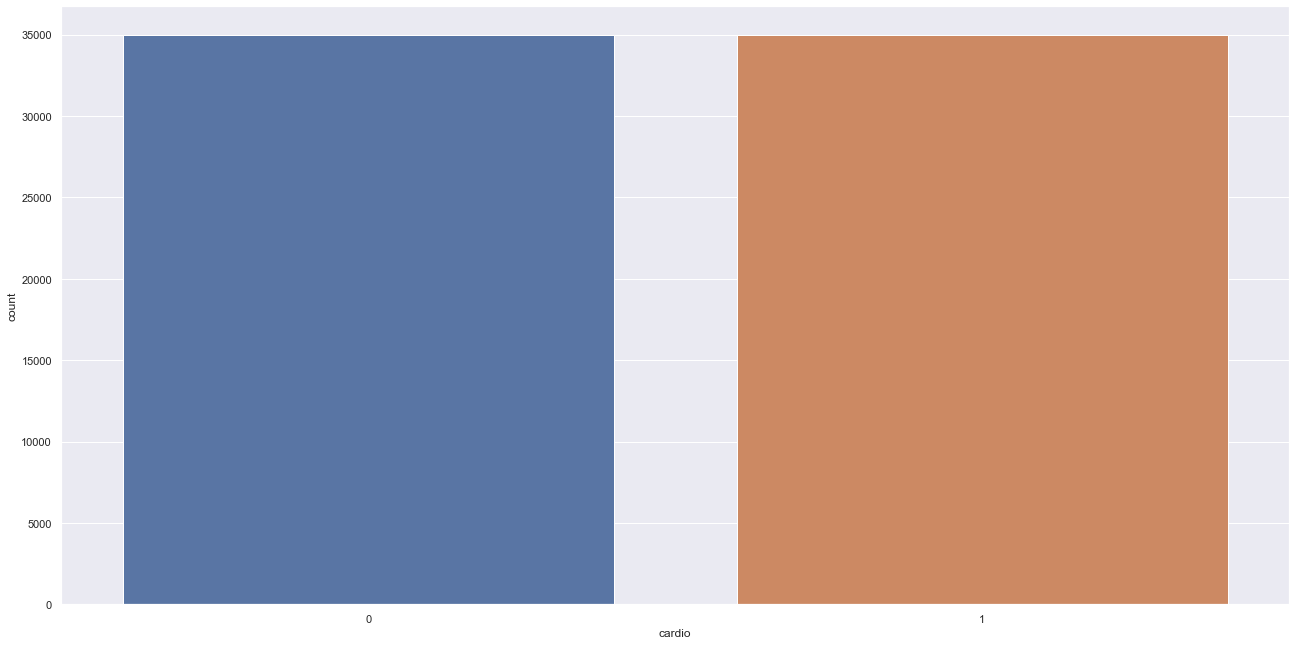

In [41]:
sns.countplot( df4['cardio'], );

In [42]:
detected = df4[df4['cardio'] == 1].count()[0]
total = df4.shape[0]
detected

print( 'Percentage of people with cardiac conditions: {:.2f}%'.format(detected/total*100 ) )

Percentage of people with cardiac conditions: 49.98%


### 4.1.2 Numerical Features

In [43]:
cat_features = ['gender', 'cholesterol', 'glucose', 'smoking', 'alcohol', 'active', 'cardio', 'cardio_cat'] 
num_features = [ 'age_years', 'height', 'weight', 'bmi', 'sbp', 'dbp', 'cardio', 'cardio_cat' ]

In [44]:
num_att = df4[num_features]
cat_att = df4[cat_features]

#### 4.1.2.1 Age

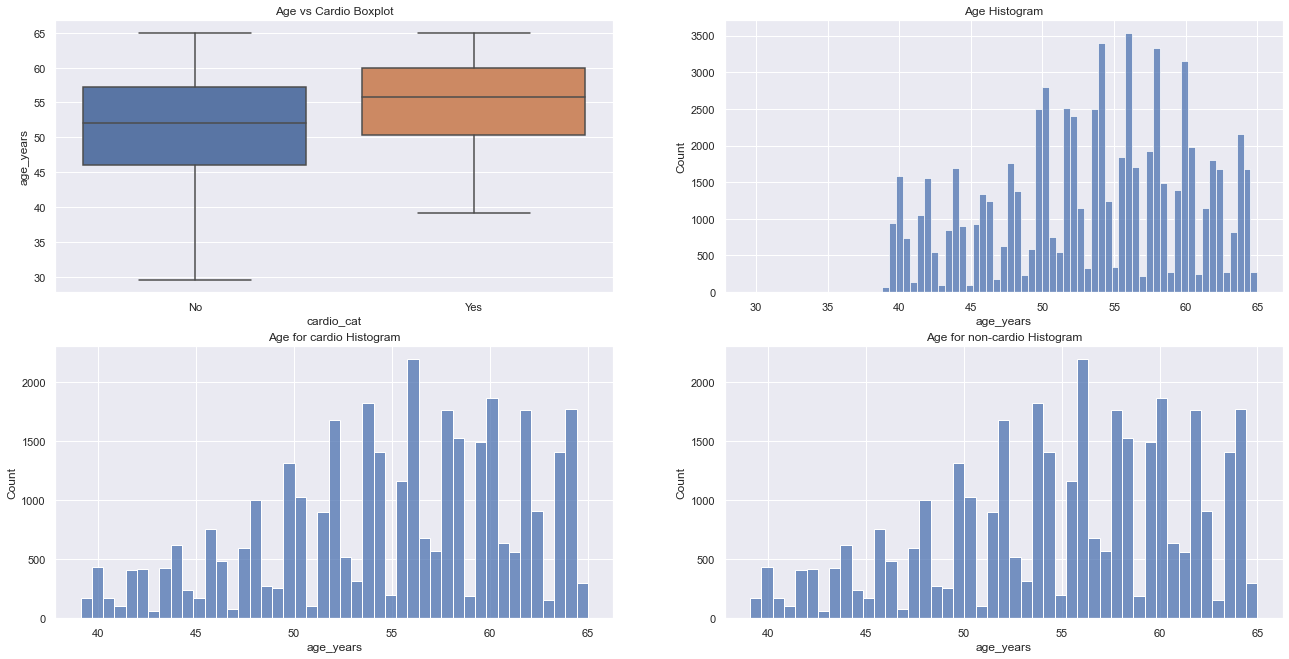

In [45]:
#age
plt.subplot(2, 2, 1)
sns.boxplot(x = 'cardio_cat', y = 'age_years', data = df4);
plt.title('Age vs Cardio Boxplot');

plt.subplot(2, 2, 2)
sns.histplot(df4['age_years']);
plt.title('Age Histogram');

plt.subplot(2, 2, 3)
aux1 = df4[ df4['cardio'] == 1 ]
sns.histplot(aux1['age_years']);
plt.title('Age for cardio Histogram');

plt.subplot(2, 2, 4)
aux2 = df4[ df4['cardio'] == 0 ]
sns.histplot(aux1['age_years']);
plt.title('Age for non-cardio Histogram');

#### 4.1.2.2 Height

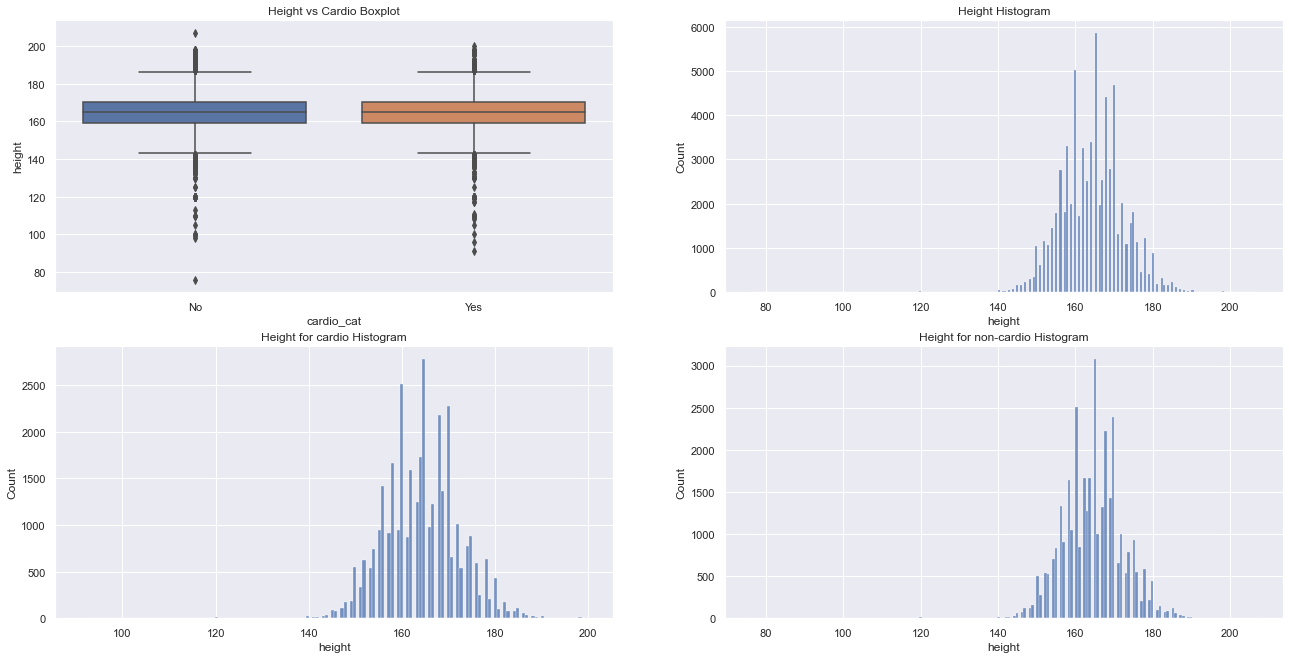

In [46]:
#height
plt.subplot(2, 2, 1)
sns.boxplot(x = 'cardio_cat', y = 'height', data = df4);
plt.title('Height vs Cardio Boxplot');

plt.subplot(2, 2, 2)
sns.histplot(df4['height']);
plt.title('Height Histogram');

plt.subplot(2, 2, 3)
sns.histplot(aux1['height']);
plt.title('Height for cardio Histogram');

plt.subplot(2, 2, 4)
sns.histplot(aux2['height']);
plt.title('Height for non-cardio Histogram');

#### 4.1.2.3 Weight

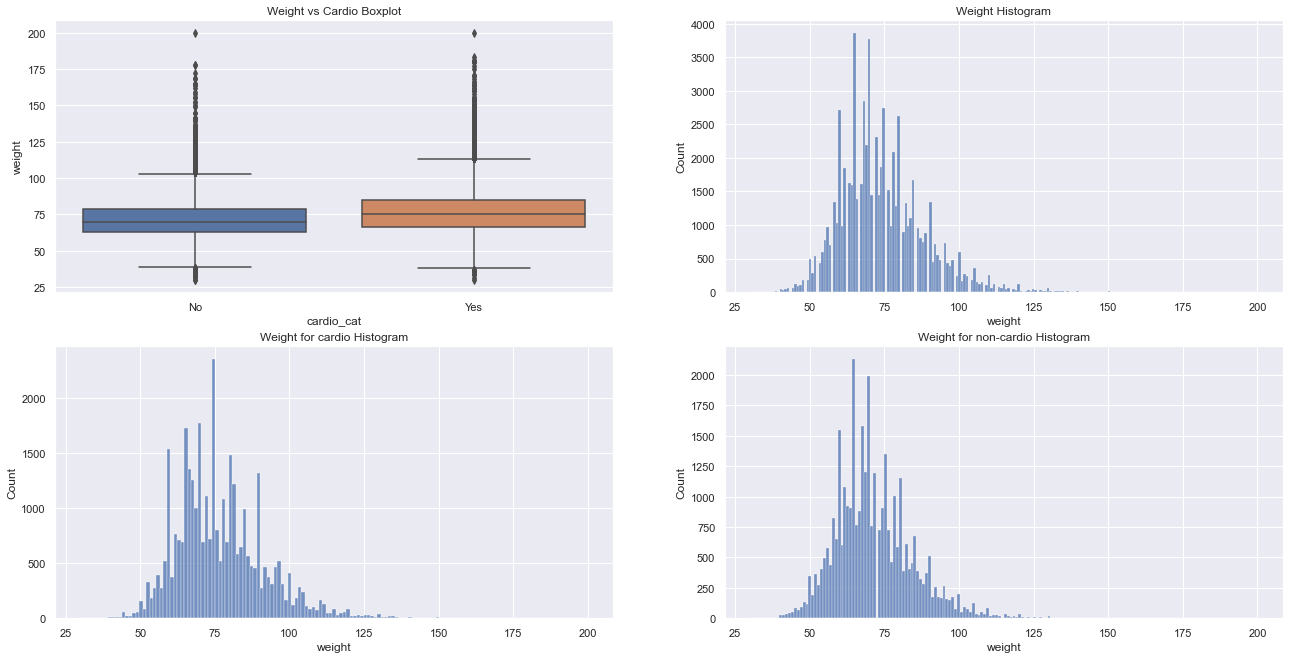

In [47]:
#weight
plt.subplot(2, 2, 1)
sns.boxplot(x = 'cardio_cat', y = 'weight', data = df4);
plt.title('Weight vs Cardio Boxplot');

plt.subplot(2, 2, 2)
sns.histplot(df4['weight']);
plt.title('Weight Histogram');

plt.subplot(2, 2, 3)
sns.histplot(aux1['weight']);
plt.title('Weight for cardio Histogram');

plt.subplot(2, 2, 4)
sns.histplot(aux2['weight']);
plt.title('Weight for non-cardio Histogram');

#### 4.1.2.4 BMI

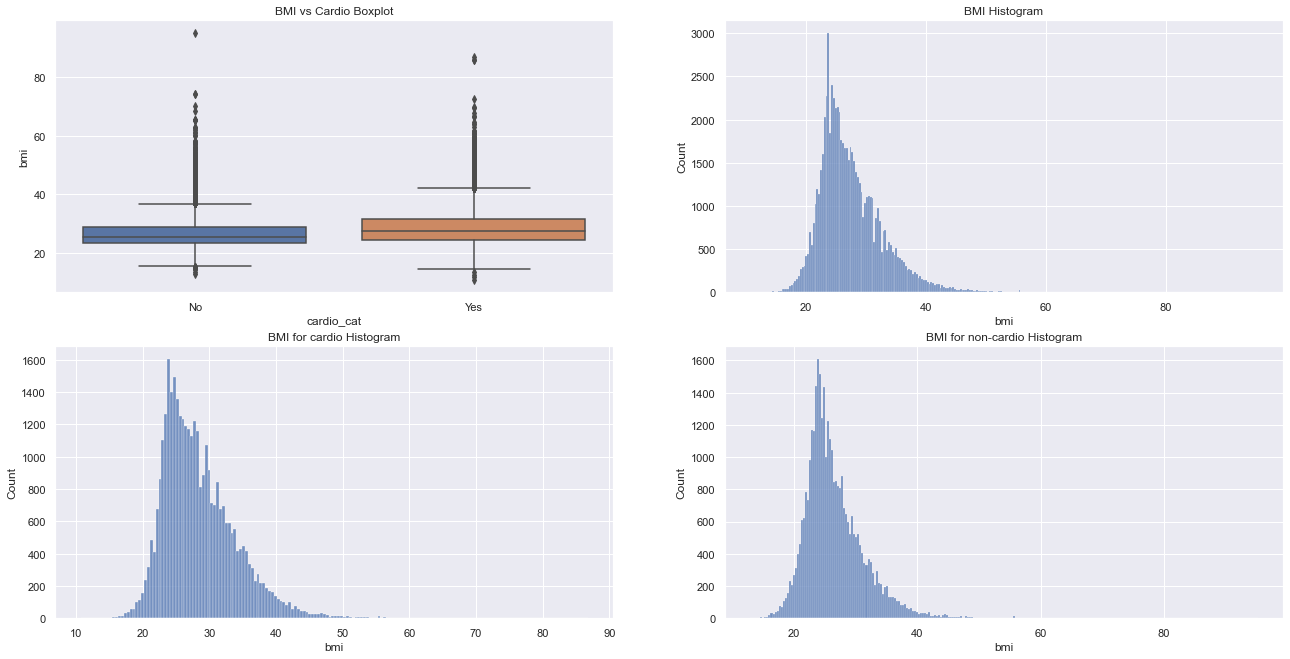

In [48]:
#bmi
plt.subplot(2, 2, 1)
sns.boxplot(x = 'cardio_cat', y = 'bmi', data = df4);
plt.title('BMI vs Cardio Boxplot');

plt.subplot(2, 2, 2)
sns.histplot(df4['bmi']);
plt.title('BMI Histogram');

plt.subplot(2, 2, 3)
sns.histplot(aux1['bmi']);
plt.title('BMI for cardio Histogram');

plt.subplot(2, 2, 4)
sns.histplot(aux2['bmi']);
plt.title('BMI for non-cardio Histogram');

#### 4.1.2.5 Systolic Blood Pressure

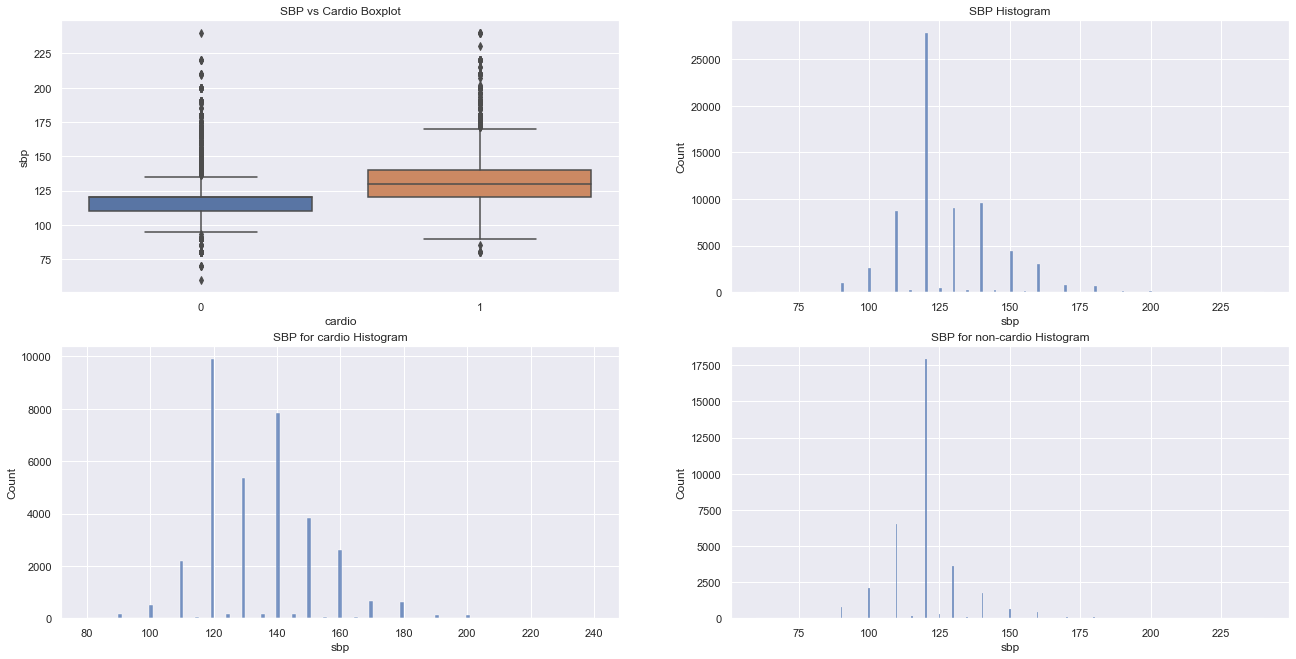

In [49]:
#SBP
plt.subplot(2, 2, 1)
sns.boxplot(x = 'cardio', y = 'sbp', data = df4);
plt.title('SBP vs Cardio Boxplot');

plt.subplot(2, 2, 2)
sns.histplot(df4['sbp']);
plt.title('SBP Histogram');

plt.subplot(2, 2, 3)
sns.histplot(aux1['sbp']);
plt.title('SBP for cardio Histogram');

plt.subplot(2, 2, 4)
sns.histplot(aux2['sbp']);
plt.title('SBP for non-cardio Histogram');

#### 4.1.2.6 Diastolic Blood Pressure

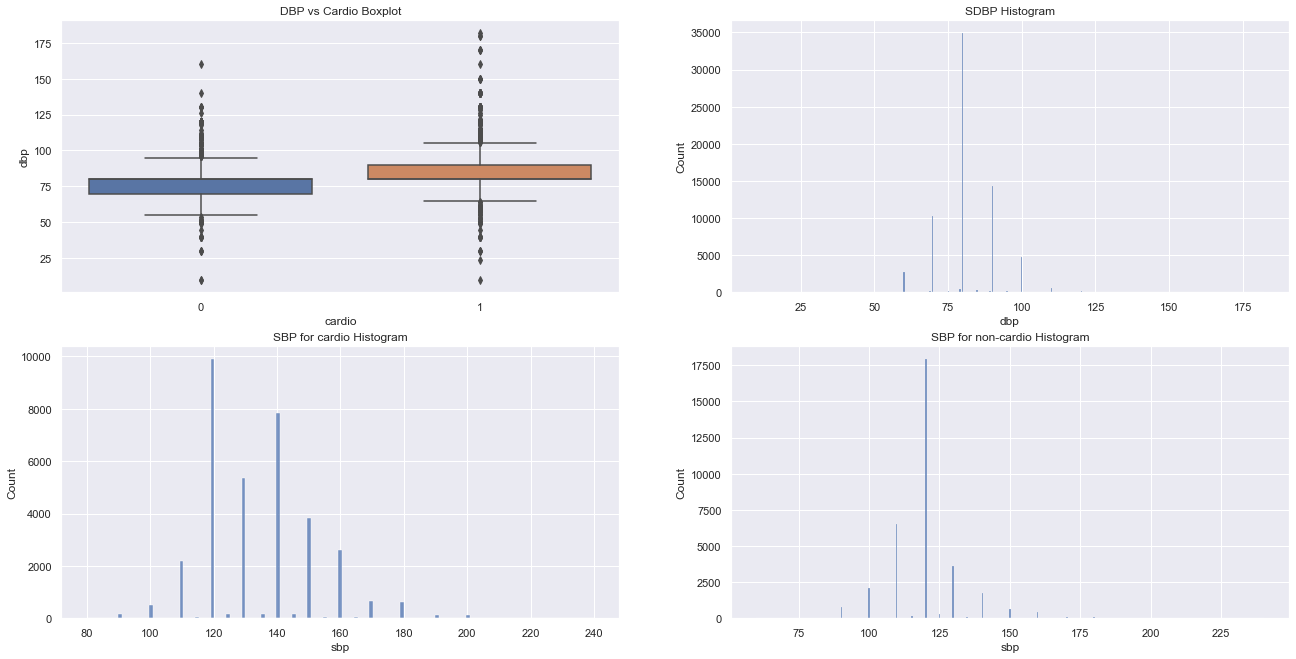

In [50]:
#DBP
plt.subplot(2, 2, 1)
sns.boxplot(x = 'cardio', y = 'dbp', data = df4);
plt.title('DBP vs Cardio Boxplot');

plt.subplot(2, 2, 2)
sns.histplot(df4['dbp']);
plt.title('SDBP Histogram');

plt.subplot(2, 2, 3)
sns.histplot(aux1['sbp']);
plt.title('SBP for cardio Histogram');

plt.subplot(2, 2, 4)
sns.histplot(aux2['sbp']);
plt.title('SBP for non-cardio Histogram');

#### 4.1.2.7 Numerical Features Overall

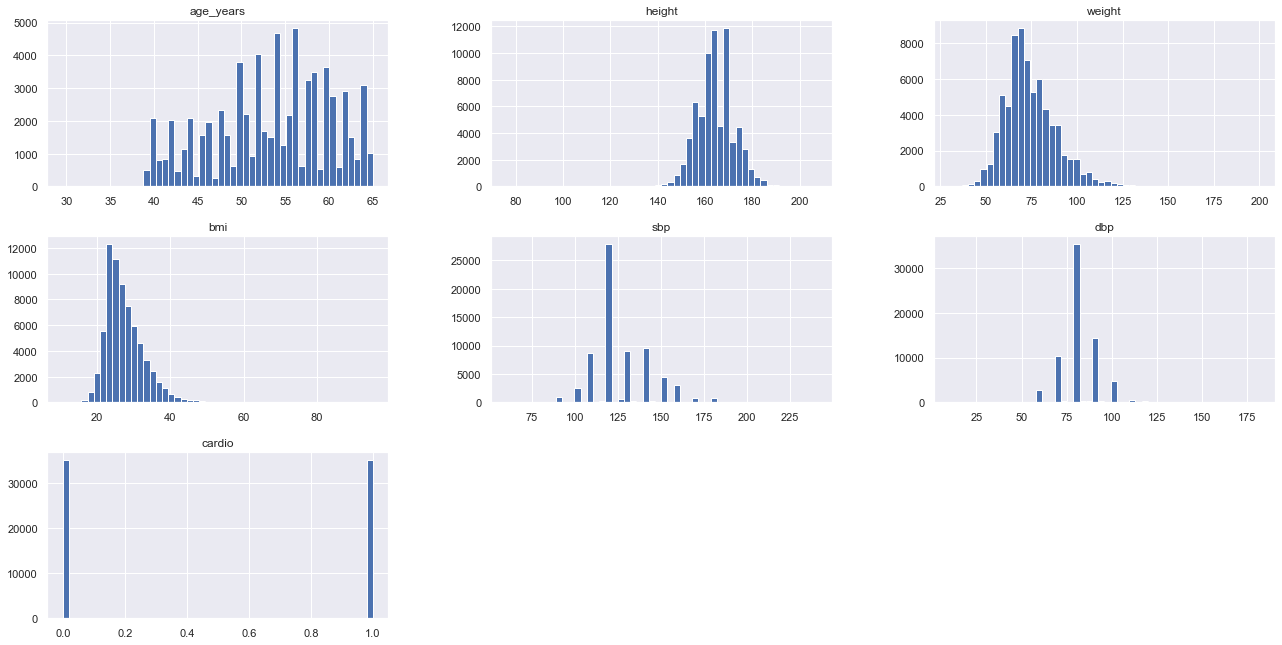

In [51]:
num_att.hist(bins = 50);

### 4.1.3 Categorical Features

In [52]:
cat_eda('gender', 'cardio_cat', cat_att)

,gender,cardio_cat,%
0,Female,No,17.288858
1,Female,Yes,17.664889
2,Male,No,32.734734
3,Male,Yes,32.311520


In [53]:
cat_eda('cholesterol', 'cardio', cat_att)

,cholesterol,cardio,%
0,Above normal,0,5.430291
1,Above normal,1,8.215496
2,Normal,0,41.891022
3,Normal,1,32.939192
4,Well above normal,0,2.702278
5,Well above normal,1,8.821721


In [54]:
cat_eda('glucose', 'cardio', cat_att)

,glucose,cardio,%
0,Above normal,0,3.019688
1,Above normal,1,4.397993
2,Normal,0,44.122904
3,Normal,1,40.841566
4,Well above normal,0,2.881000
5,Well above normal,1,4.736850


In [55]:
cat_eda('smoking', 'cardio', cat_att)

,smoking,cardio,%
0,No,0,45.395405
1,No,1,45.792883
2,Yes,0,4.628187
3,Yes,1,4.183526


In [56]:
cat_eda('alcohol', 'cardio', cat_att)

,alcohol,cardio,%
0,No,0,47.252684
1,No,1,47.371356
2,Yes,0,2.770907
3,Yes,1,2.605053


In [57]:
cat_eda('active', 'cardio', cat_att)

,active,cardio,%
0,No,0,9.109106
1,No,1,10.518866
2,Yes,0,40.914485
3,Yes,1,39.457543


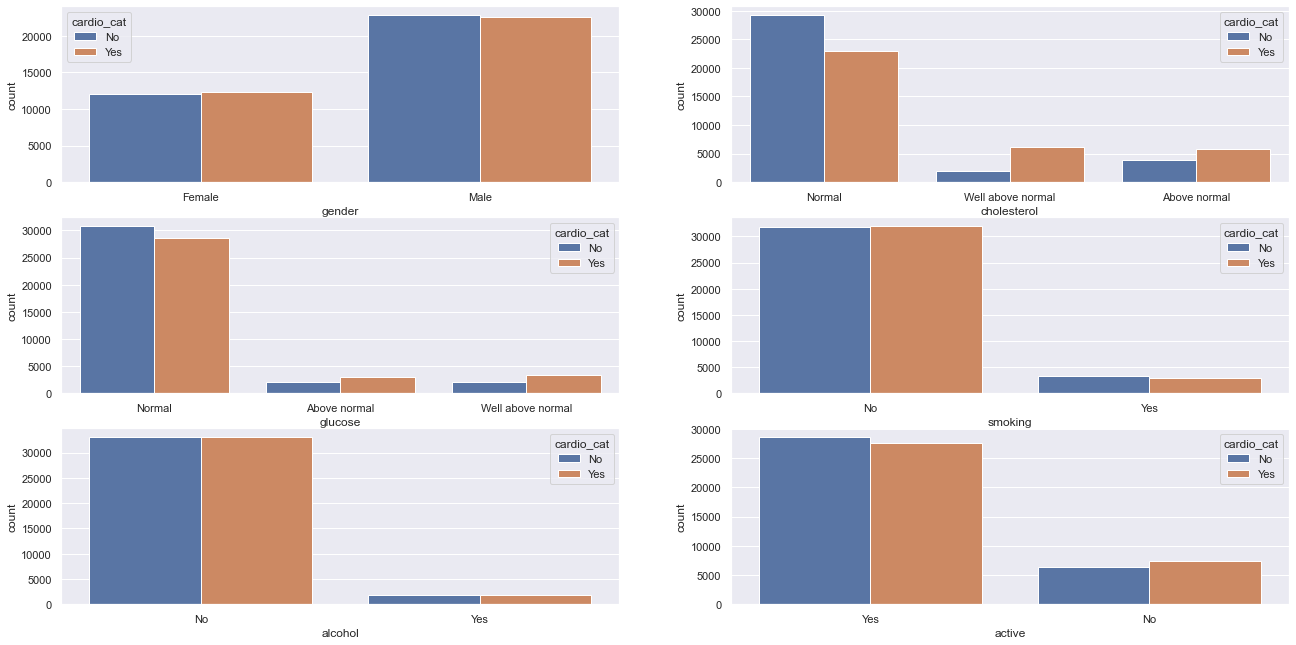

In [58]:
plt.subplot( 3, 2, 1 )
sns.countplot( x = 'gender', hue = 'cardio_cat', data = cat_att );

plt.subplot( 3, 2, 2 )
sns.countplot( x = 'cholesterol', hue = 'cardio_cat', data = cat_att );

plt.subplot( 3, 2, 3 )
sns.countplot( x = 'glucose', hue = 'cardio_cat', data = cat_att );

plt.subplot( 3, 2, 4 )
sns.countplot( x = 'smoking', hue = 'cardio_cat', data = cat_att );

plt.subplot( 3, 2, 5 )
sns.countplot( x = 'alcohol', hue = 'cardio_cat', data = cat_att );

plt.subplot( 3, 2, 6 )
sns.countplot( x = 'active', hue = 'cardio_cat', data = cat_att );

## 4.2 Bivariate Analysis

### **H1.** Female customers are more likely to have cardiovascular diseases.
**False** - Women actually have higher numbers, but the difference is so narrow that it can't even be acknowledged.

In [59]:
df4[ ['gender', 'cardio'] ].groupby('gender').sum().reset_index()

,gender,cardio
0,Female,12355
1,Male,22599


In [60]:
aux = df4.copy()
aux = aux.groupby('gender')['cardio'].agg(['sum', 'count'])
aux['%'] = round(aux['sum']/aux['count']*100,2)
aux.head()

,sum,count,%
gender,,,
Female,12355,24447,50.54
Male,22599,45494,49.67


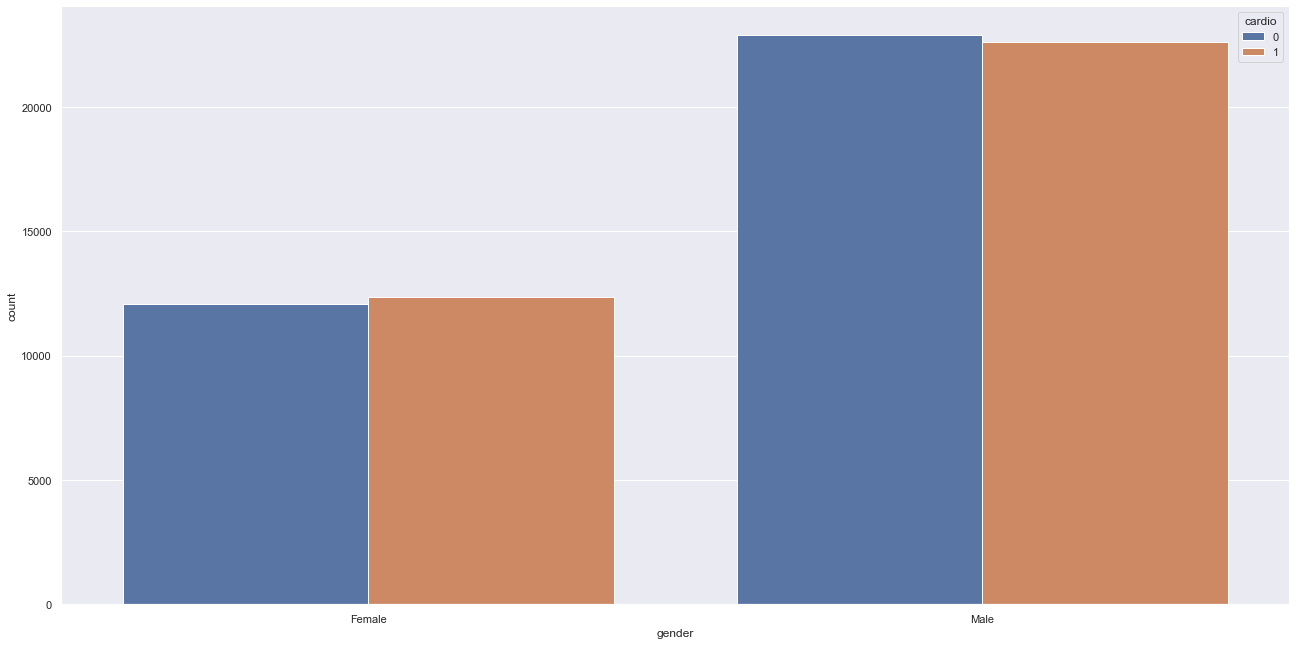

In [61]:
sns.countplot( x = 'gender', hue = 'cardio', data = df4);

### **H2.** Customers who are 55 or older are more likely to have cardiovascular diseases.
**True** - Customers who are 55 or older are indeed more likely to have cardiovascular diseases.

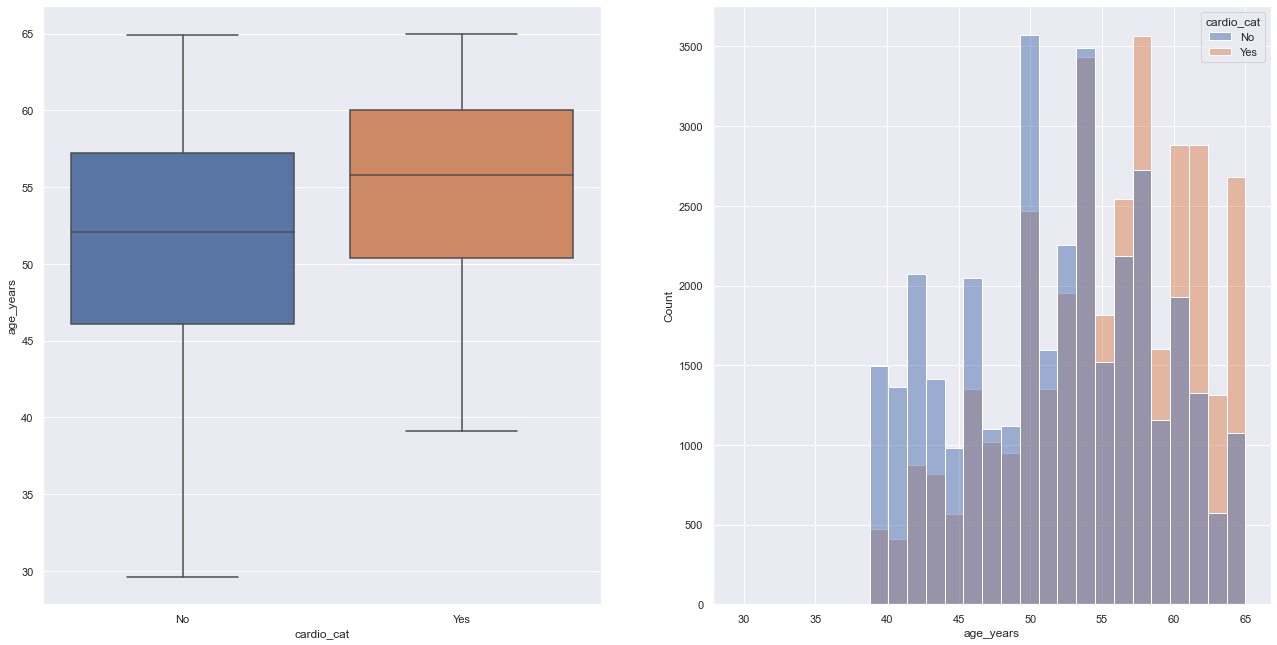

In [62]:
plt.subplot(1, 2, 1)
sns.boxplot(y = 'age_years', x = 'cardio_cat', data = df4);

plt.subplot(1, 2, 2)
sns.histplot(x = 'age_years', hue = 'cardio_cat', bins = 27, data = df4);

In [63]:
aux = df4.copy()
aux['54_to_55'] = aux['age_years'].apply( lambda x: 1 if ((x >= 54) & (x<55)) else 0)
aux = aux[['54_to_55', 'id', 'cardio_cat']].groupby(['54_to_55', 'cardio_cat']).count().reset_index()
aux.head()

,54_to_55,cardio_cat,id
0,0,No,32939
1,0,Yes,33022
2,1,No,2048
3,1,Yes,1932


In [64]:
aux = df4.copy()
aux['55_to_56'] = aux['age_years'].apply( lambda x: 1 if ((x >= 55) & (x<56)) else 0)
aux = aux[['55_to_56', 'id', 'cardio_cat']].groupby(['55_to_56', 'cardio_cat']).count().reset_index()
aux.head()

,55_to_56,cardio_cat,id
0,0,No,33390
1,0,Yes,32995
2,1,No,1597
3,1,Yes,1959


### **H3.** Customers with body mass index above 35 are more likely to have cardiovascular diseases.
**False** - Customers with BMI higher than 27 are more likely to have a cardiac issue than not.

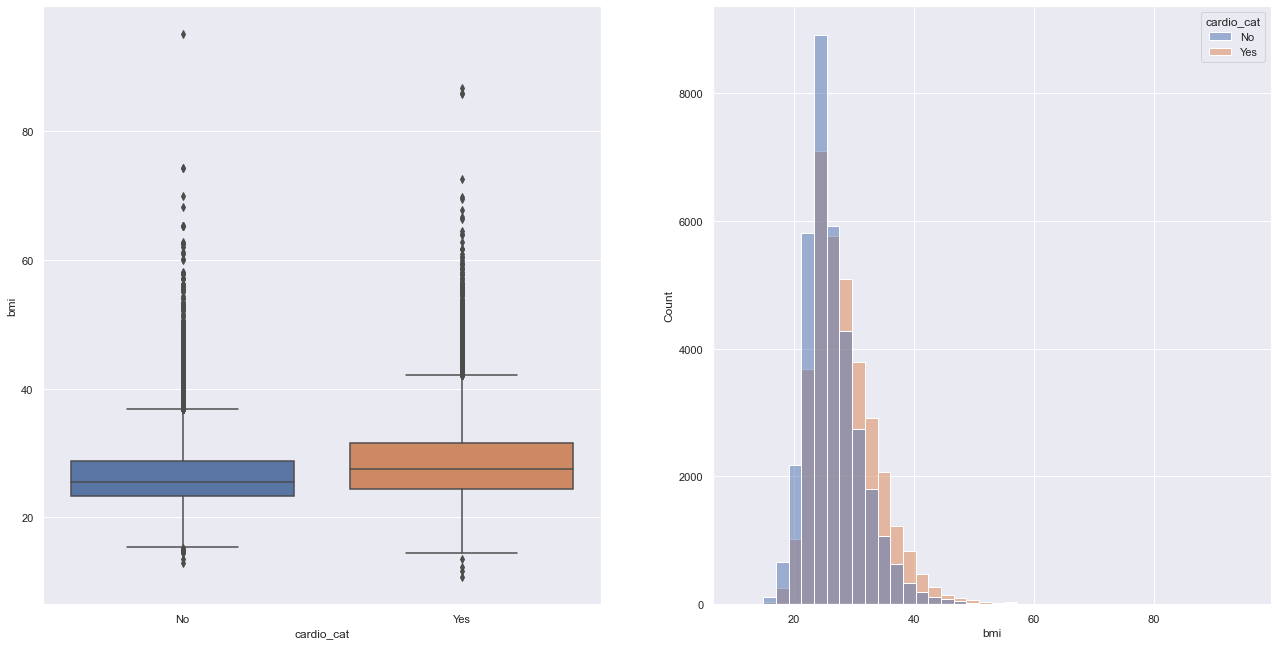

In [65]:
plt.subplot(1, 2, 1)
sns.boxplot(y = 'bmi', x = 'cardio_cat', data = df4);

plt.subplot(1, 2, 2)
sns.histplot(x = 'bmi', hue = 'cardio_cat', bins = 40, data = df4);

In [66]:
aux = df4.copy()
aux['26_to_27'] = aux['bmi'].apply( lambda x: 1 if ((x >= 26) & (x <27)) else 0)
aux = aux[['26_to_27', 'id', 'cardio_cat']].groupby(['26_to_27', 'cardio_cat']).count().reset_index()
aux

,26_to_27,cardio_cat,id
0,0,No,32181
1,0,Yes,32227
2,1,No,2806
3,1,Yes,2727


In [67]:
aux = df4.copy()
aux['27_to_28'] = aux['bmi'].apply( lambda x: 1 if ((x >= 27) & (x <28)) else 0)
aux = aux[['27_to_28', 'id', 'cardio_cat']].groupby(['27_to_28', 'cardio_cat']).count().reset_index()
aux


,27_to_28,cardio_cat,id
0,0,No,32469
1,0,Yes,32258
2,1,No,2518
3,1,Yes,2696


### **H4.** Customers whose systolic blood pressure levels are higher than 130 are more likely to have cardiovascular diseases.
**True** - Customers whose systolic blood pressure levels are higher than 130 are indeed more likely to have cardiovascular diseases.

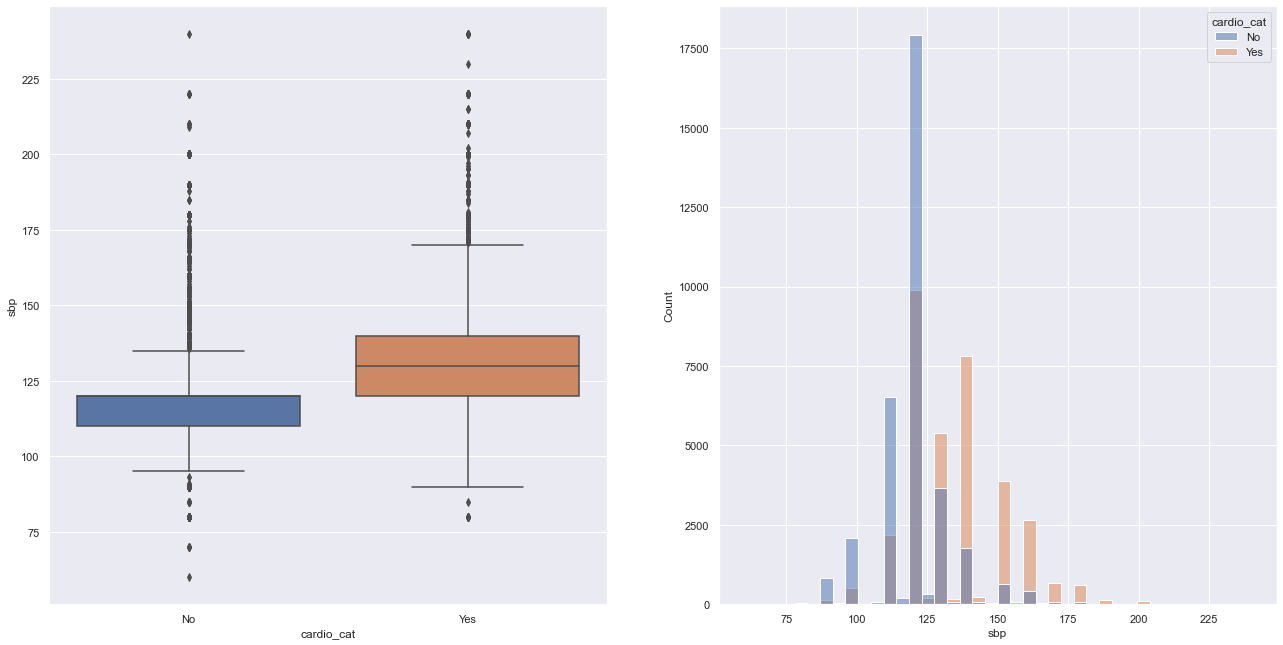

In [68]:
plt.subplot(1, 2, 1)
sns.boxplot(y = 'sbp', x = 'cardio_cat', data = df4);

plt.subplot(1, 2, 2)
sns.histplot(x = 'sbp', hue = 'cardio_cat', bins = 40, data = df4);

In [69]:
aux = df4.copy()
aux['125_to_130'] = aux['sbp'].apply( lambda x: 1 if ((x >= 125) & (x <130)) else 0)
aux = aux[['125_to_130', 'id', 'cardio_cat']].groupby(['125_to_130', 'cardio_cat']).count().reset_index()
aux

,125_to_130,cardio_cat,id
0,0,No,34663
1,0,Yes,34759
2,1,No,324
3,1,Yes,195


In [70]:
aux = df4.copy()
aux['130_to_135'] = aux['sbp'].apply( lambda x: 1 if ((x >= 130) & (x <135)) else 0)
aux = aux[['130_to_135', 'id', 'cardio_cat']].groupby(['130_to_135', 'cardio_cat']).count().reset_index()
aux

,130_to_135,cardio_cat,id
0,0,No,31346
1,0,Yes,29563
2,1,No,3641
3,1,Yes,5391


### **H5.** Customers whose diastolic blood pressure levels are higher than 80 are more likely to have cardiovascular diseases.
**False** - Customers whose diastolic blood pressure levels are higher than 85 are more likely to have cardiovascular diseases.

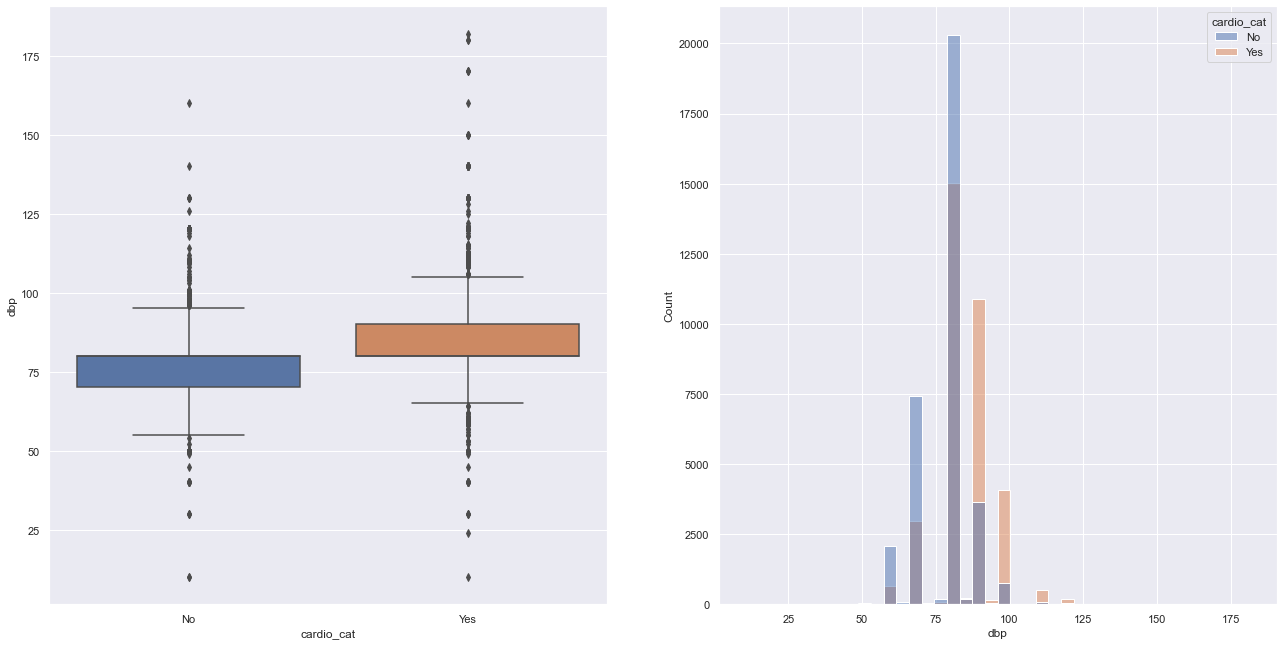

In [71]:
plt.subplot(1, 2, 1)
sns.boxplot(y = 'dbp', x = 'cardio_cat', data = df4);

plt.subplot(1, 2, 2)
sns.histplot(x = 'dbp', hue = 'cardio_cat', bins = 40, data = df4);

In [72]:
aux = df4.copy()
aux['75_to_80'] = aux['dbp'].apply( lambda x: 1 if ((x >= 75) & (x <80)) else 0)
aux = aux[['75_to_80', 'id', 'cardio_cat']].groupby(['75_to_80', 'cardio_cat']).count().reset_index()
aux

,75_to_80,cardio_cat,id
0,0,No,34603
1,0,Yes,34706
2,1,No,384
3,1,Yes,248


In [73]:
aux = df4.copy()
aux['80_to_85'] = aux['dbp'].apply( lambda x: 1 if ((x >= 80) & (x <85)) else 0)
aux = aux[['80_to_85', 'id', 'cardio_cat']].groupby(['80_to_85', 'cardio_cat']).count().reset_index()
aux

,80_to_85,cardio_cat,id
0,0,No,14864
1,0,Yes,20066
2,1,No,20123
3,1,Yes,14888


In [74]:
aux = df4.copy()
aux['85_to_90'] = aux['dbp'].apply( lambda x: 1 if ((x >= 85) & (x <90)) else 0)
aux = aux[['85_to_90', 'id', 'cardio_cat']].groupby(['85_to_90', 'cardio_cat']).count().reset_index()
aux

,85_to_90,cardio_cat,id
0,0,No,34781
1,0,Yes,34666
2,1,No,206
3,1,Yes,288


### **H6.** Customers whose cholesterol levels are well above normal are more likely to have cardiovascular diseases.
**True** - Customers whose cholesterol levels are well above normal are indeed more likely to have cardiovascular diseases.

<AxesSubplot:xlabel='cholesterol', ylabel='count'>

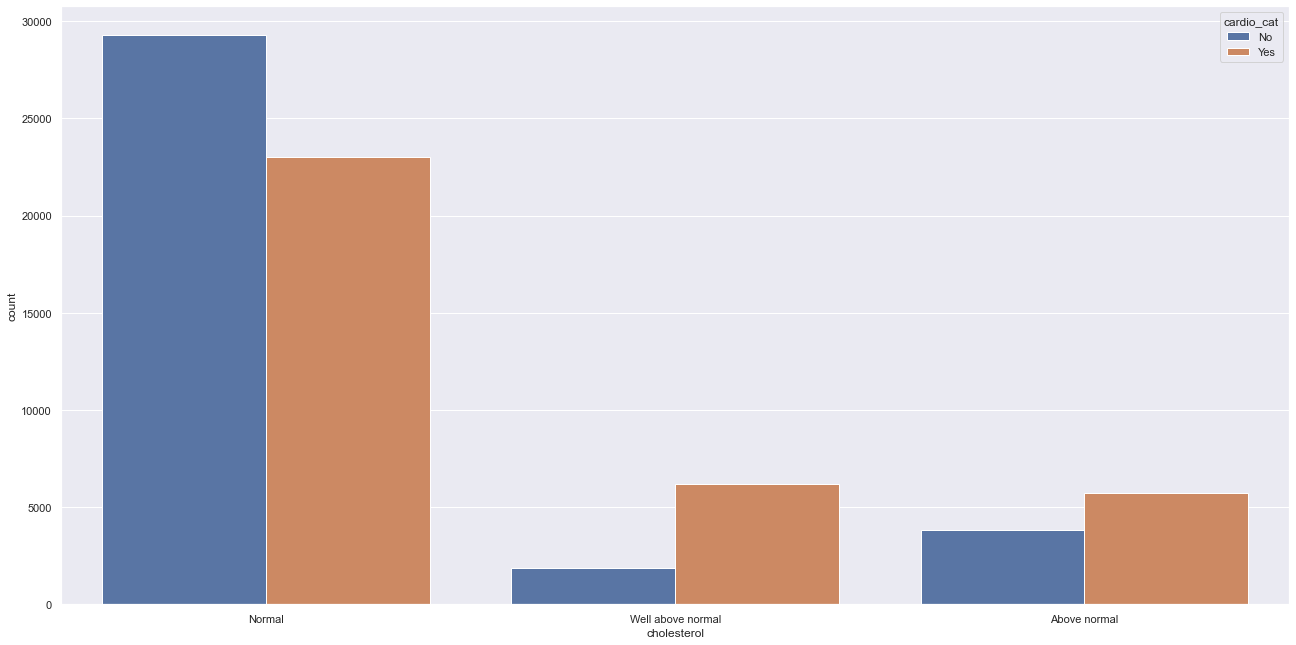

In [75]:
sns.countplot( x = 'cholesterol', hue = 'cardio_cat', data = df4)

In [76]:
aux = df4.copy()
aux = aux.groupby('cholesterol')['cardio'].agg(['sum', 'count'])
aux['%'] = round(aux['sum']/aux['count']*100,2)
aux.head()

,sum,count,%
cholesterol,,,
Above normal,5746,9544,60.21
Normal,23038,52337,44.02
Well above normal,6170,8060,76.55


### **H7.** Customers whose glucose levels are well above normal are more likely to have cardiovascular diseases.
**True** - Customers whose glucose levels are well above normal are more likely to have cardiovascular diseases, but not much more likely than those with above normal glucose levels.

<AxesSubplot:xlabel='glucose', ylabel='count'>

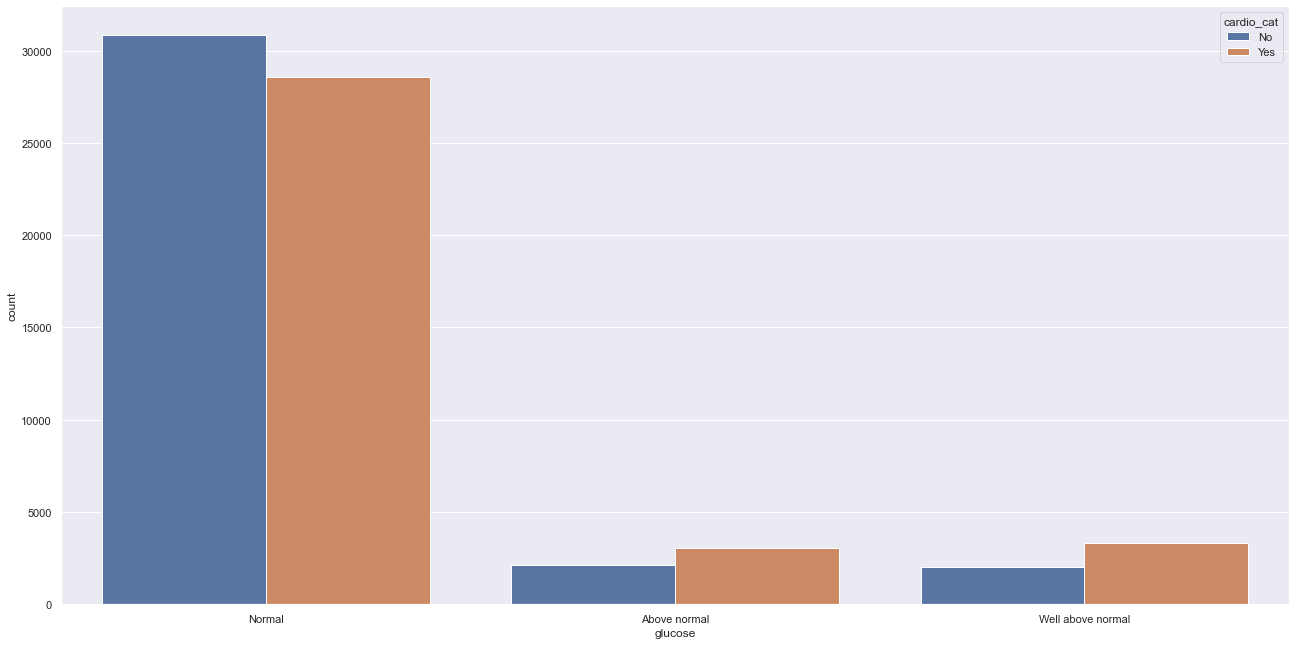

In [77]:
sns.countplot( x = 'glucose', hue = 'cardio_cat', data = df4)

In [78]:
aux = df4.copy()
aux = aux.groupby('glucose')['cardio'].agg(['sum', 'count'])
aux['%'] = round(aux['sum']/aux['count']*100,2)
aux.head()

,sum,count,%
glucose,,,
Above normal,3076,5188,59.29
Normal,28565,59425,48.07
Well above normal,3313,5328,62.18


### **H8.** Smoker customers are more likely to have cardiovascular diseases.
**False** - Less than half of customer that smoke suffer from cardio issues. Probability is roughly the same for non-smokers.

<AxesSubplot:xlabel='smoking', ylabel='count'>

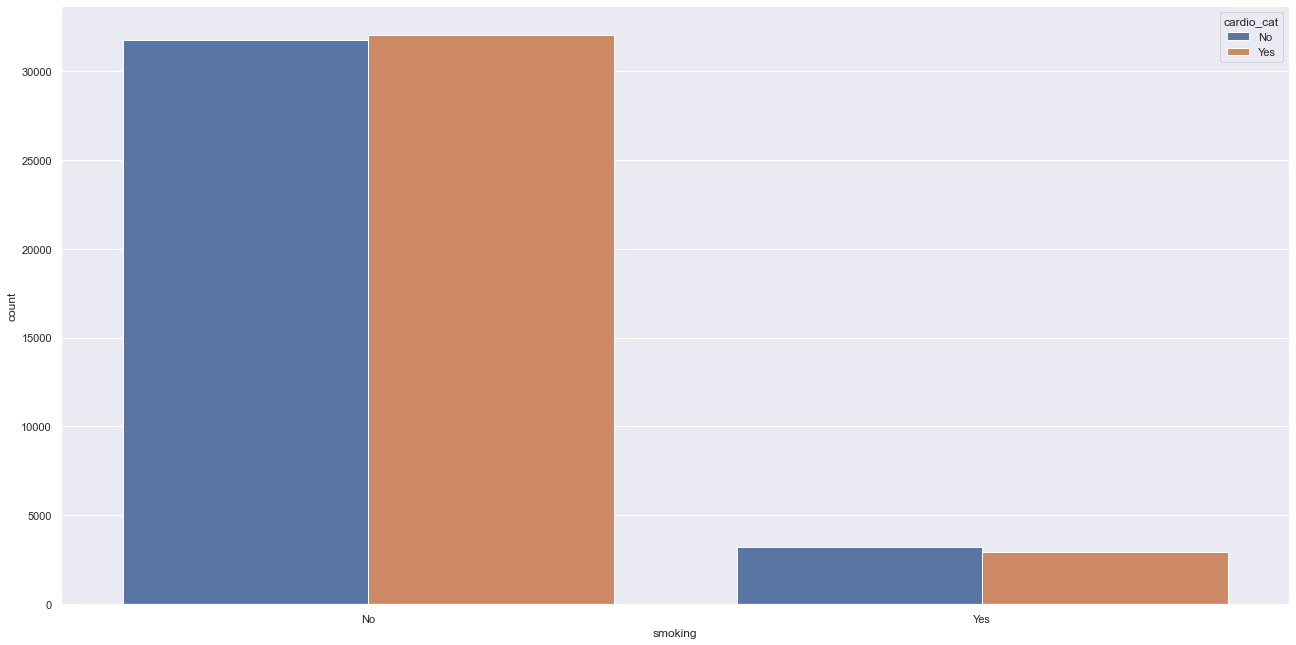

In [79]:
sns.countplot( x = 'smoking', hue = 'cardio_cat', data = df4)

In [80]:
aux = df4.copy()
aux = aux.groupby('smoking')['cardio'].agg(['sum', 'count'])
aux['%'] = round(aux['sum']/aux['count']*100,2)
aux.head()

,sum,count,%
smoking,,,
No,32028,63778,50.22
Yes,2926,6163,47.48


### **H9.** Customers who drink alcohol regularly are more likely to have cardiovascular diseases.
**False** - Less than half of customer that drink suffer from cardio issues. Probability is roughly the same for those who don't drink.

<AxesSubplot:xlabel='alcohol', ylabel='count'>

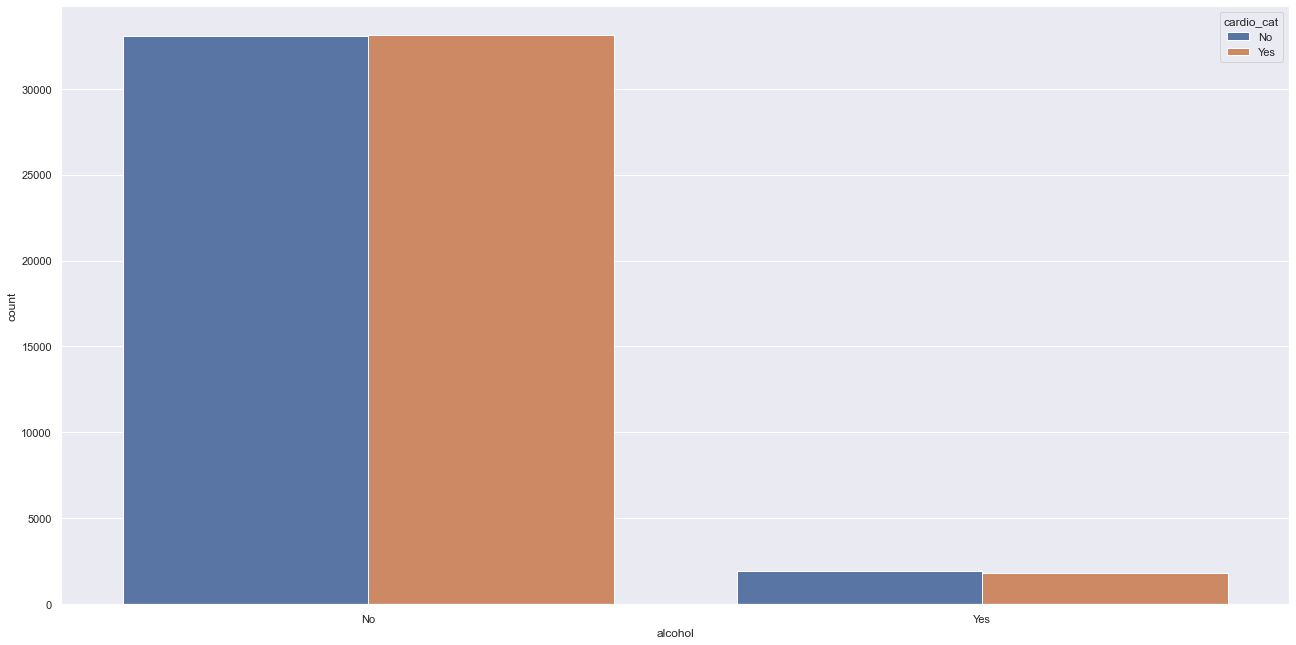

In [81]:
sns.countplot( x = 'alcohol', hue = 'cardio_cat', data = df4)

In [82]:
aux = df4.copy()
aux = aux.groupby('alcohol')['cardio'].agg(['sum', 'count'])
aux['%'] = round(aux['sum']/aux['count']*100,2)
aux.head()

,sum,count,%
alcohol,,,
No,33132,66181,50.06
Yes,1822,3760,48.46


### H10. Sedentary customers are more likely to have cardiovascular diseases..
**True** - Less than half of customer that exercise regularly suffer from cardio issues. Probability is not that off for those who don't exercise regularly.

<AxesSubplot:xlabel='active', ylabel='count'>

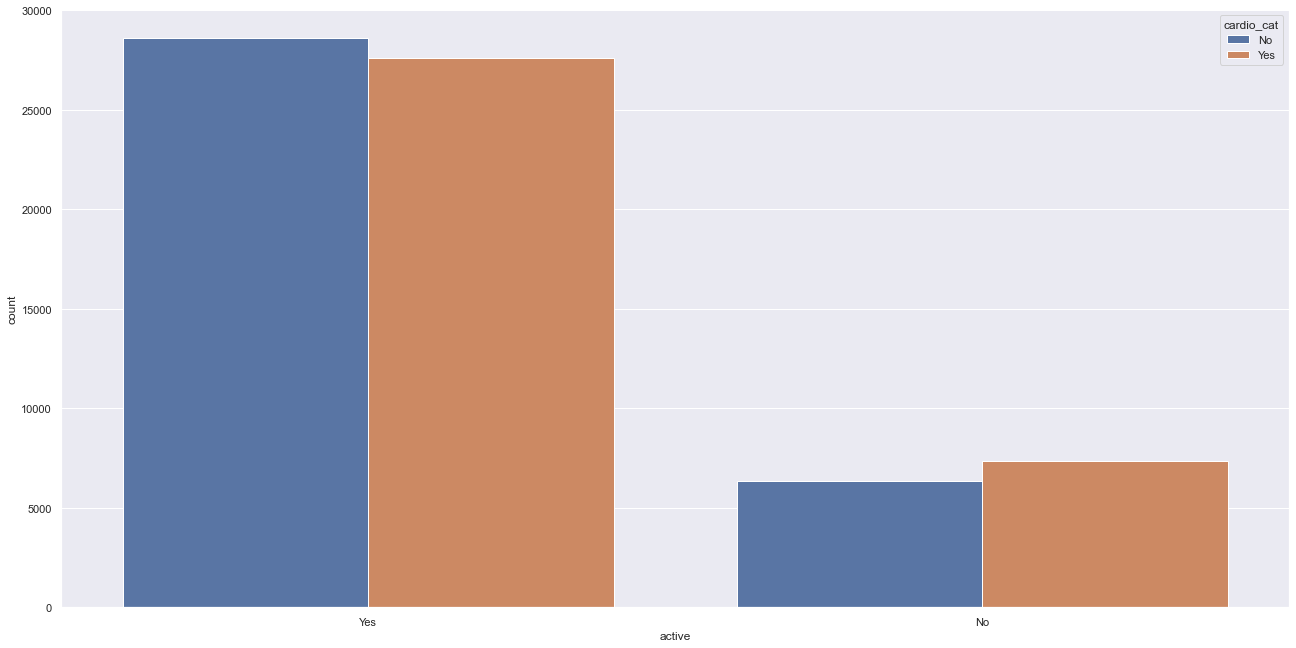

In [83]:
sns.countplot( x = 'active', hue = 'cardio_cat', data = df4)

In [84]:
aux = df4.copy()
aux = aux.groupby('active')['cardio'].agg(['sum', 'count'])
aux['%'] = round(aux['sum']/aux['count']*100,2)
aux.head()

,sum,count,%
active,,,
No,7357,13728,53.59
Yes,27597,56213,49.09


### 4.2.1 Bivariate analysis overview

In [85]:
tab = [ [ 'Hypothesis', 'Status', 'Importance'],
      ['H1', 'False', 'Low'],
      ['H2', 'True', 'High'],
      ['H3', 'False', 'Medium'],
      ['H4', 'True', 'High'],
      ['H5', 'False', 'High'],
      ['H6', 'True', 'High'],
      ['H7', 'True', 'Medium'],
      ['H8', 'False', 'Low'],
      ['H9', 'False', 'Low'],
      ['H10', 'True', 'Low'],
                  ]

print ( tabulate( tab , headers = 'firstrow') )

Hypothesis    Status    Importance
------------  --------  ------------
H1            False     Low
H2            True      High
H3            False     Medium
H4            True      High
H5            False     High
H6            True      High
H7            True      Medium
H8            False     Low
H9            False     Low
H10           True      Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Features

In [86]:
df4.head()

,id,age_years,gender,height,weight,bmi,sbp,dbp,cholesterol,glucose,smoking,alcohol,active,cardio,cardio_cat
0,0,50.4,Female,168,62.0,21.97,110.0,80.0,Normal,Normal,No,No,Yes,0,No
1,1,55.4,Male,156,85.0,34.93,140.0,90.0,Well above normal,Normal,No,No,Yes,1,Yes
2,2,51.7,Male,165,64.0,23.51,130.0,70.0,Well above normal,Normal,No,No,No,1,Yes
3,3,48.3,Female,169,82.0,28.71,150.0,100.0,Normal,Normal,No,No,Yes,1,Yes
4,4,47.9,Male,156,56.0,23.01,100.0,60.0,Normal,Normal,No,No,No,0,No


In [87]:
num_features = df4

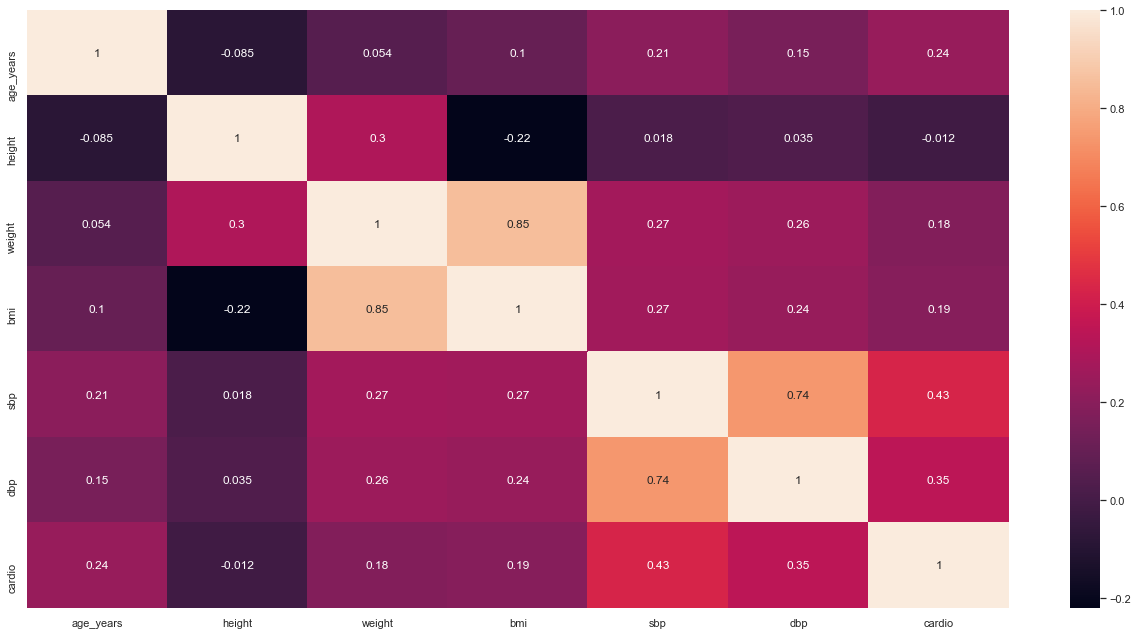

In [88]:
sns.heatmap( num_att.corr( method = 'pearson') , annot = True );

### 4.3.2 Categorical Features

In [89]:
cat_att = cat_att.drop('cardio', axis = 1)

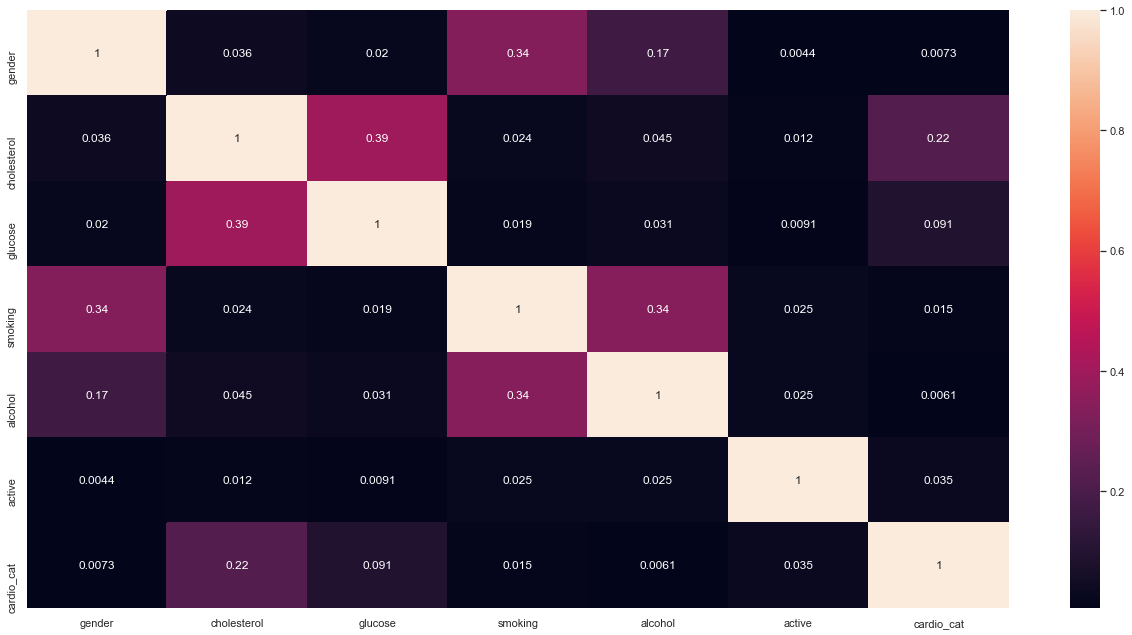

In [90]:
cat_corr = cramers_v(cat_att)

In [91]:
cols_drop = ['cardio_cat']
df4 = df4.drop(cols_drop, axis = 1)

# 5.0 STEP 05 - DATA PREPARATION

In [92]:
df5 = df4.copy()

## 5.0.1 Train and validation data split

In [93]:
X = df5.drop(['cardio'], axis = 1)
y = df5['cardio']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

df5 = pd.concat( [X_train, y_train], axis = 1)

## 5.1 Standardization

In [94]:
ss_height = pp.StandardScaler()
ss_weight = pp.StandardScaler()
ss_bmi = pp.StandardScaler()
ss_sbp = pp.StandardScaler()
ss_dbp = pp.StandardScaler()

In [95]:
#height
df5['height'] = ss_height.fit_transform( df5[['height']].values )
pickle.dump( ss_height, open( 'parameters/height_scaler.pkl', 'wb' ) )

#weight
df5['weight'] = ss_weight.fit_transform( df5[['weight']].values )
pickle.dump( ss_weight, open( 'parameters/weight_scaler.pkl', 'wb' ) )

#BMI
df5['bmi'] = ss_bmi.fit_transform( df5[['bmi']].values )
pickle.dump( ss_bmi, open( 'parameters/bmi_scaler.pkl', 'wb' ) )

#SBP
df5['sbp'] = ss_sbp.fit_transform( df5[['sbp']].values )
pickle.dump( ss_sbp, open( 'parameters/sbp_scaler.pkl', 'wb' ) )

#DBP
df5['dbp'] = ss_dbp.fit_transform( df5[['dbp']].values )
pickle.dump( ss_dbp, open( 'parameters/dbp_scaler.pkl', 'wb' ) )

In [96]:
df5.head()

,id,age_years,gender,height,weight,bmi,sbp,dbp,cholesterol,glucose,smoking,alcohol,active,cardio
33165,47393,58.2,Male,-0.048903,-0.434114,-0.420925,-0.413923,-0.160297,Normal,Normal,No,No,Yes,1
47540,67890,64.2,Female,0.201163,-0.224800,-0.328438,-0.413923,-0.160297,Normal,Normal,No,No,Yes,1
16609,23729,39.9,Male,-0.799101,-0.782970,-0.428475,-1.234988,-2.201412,Normal,Normal,No,Yes,Yes,0
39179,55943,55.6,Male,-1.174199,1.798567,2.663219,1.931979,1.880817,Normal,Above normal,No,No,Yes,1
42056,60068,55.6,Male,-0.424002,0.124056,0.341617,1.345504,0.860260,Normal,Normal,No,No,Yes,1


## 5.2 Rescaling

In [97]:
mms_age = pp.MinMaxScaler()

In [98]:
#age
df5['age'] = mms_age.fit_transform( df5[['age_years']].values )
pickle.dump( mms_age, open( 'parameters/age_scaler.pkl', 'wb' ) )

## 5.3 Transfomation

In [99]:
#cholesterol
df5 = pd.get_dummies( df5, prefix = ['cholesterol'], columns = ['cholesterol'] )

#glucose
df5 = pd.get_dummies( df5, prefix = ['glucose'], columns = ['glucose'] )

#smoking
a_dict = {'Yes': 1, 'No': 0}
df5['smoking'] = df5['smoking'].map(a_dict)

#alcohol
df5['alcohol'] = df5['alcohol'].map(a_dict)

#active
df5['active'] = df5['active'].map(a_dict)

#gender
g_dict = {'Male': 0, 'Female': 1}
df5['gender'] = df5['gender'].map(g_dict)

In [100]:
# rename
cols_old = list(df5.columns)
cols_new = [x.lower() for x in cols_old]
cols_new = [x.replace(" ", "_") for x in cols_new]
df5.columns = cols_new

In [101]:
df5.head()

,id,age_years,gender,height,weight,bmi,sbp,dbp,smoking,alcohol,active,cardio,age,cholesterol_above_normal,cholesterol_normal,cholesterol_well_above_normal,glucose_above_normal,glucose_normal,glucose_well_above_normal
33165,47393,58.2,0,-0.048903,-0.434114,-0.420925,-0.413923,-0.160297,0,0,1,1,0.807910,0,1,0,0,1,0
47540,67890,64.2,1,0.201163,-0.224800,-0.328438,-0.413923,-0.160297,0,0,1,1,0.977401,0,1,0,0,1,0
16609,23729,39.9,0,-0.799101,-0.782970,-0.428475,-1.234988,-2.201412,0,1,1,0,0.290960,0,1,0,0,1,0
39179,55943,55.6,0,-1.174199,1.798567,2.663219,1.931979,1.880817,0,0,1,1,0.734463,0,1,0,1,0,0
42056,60068,55.6,0,-0.424002,0.124056,0.341617,1.345504,0.860260,0,0,1,1,0.734463,0,1,0,0,1,0


In [102]:
cols_drop = ['id', 'age_years']
df5 = df5.drop(cols_drop, axis = 1)

## 5.4 Prepare validation data

In [103]:
df_val = pd.concat( [X_val, y_val], axis = 1)

#standardization

ss = pp.StandardScaler()

#height
df_val['height'] = ss.fit_transform( df_val[['height']].values )

#weight
df_val['weight'] = ss.fit_transform( df_val[['weight']].values )

#BMI
df_val['bmi'] = ss.fit_transform( df_val[['bmi']].values )

#SBP
df_val['sbp'] = ss.fit_transform( df_val[['sbp']].values )

#DBP
df_val['dbp'] = ss.fit_transform( df_val[['dbp']].values )

#rescaling
mms_age = pp.MinMaxScaler()
#age
df_val['age'] = mms_age.fit_transform( df_val[['age_years']].values )
#pickle.dump( mms_age, open( 'parameters/age_scaler.pkl', 'wb' ) )

#Transformation
#cholesterol
df_val = pd.get_dummies( df_val, prefix = ['cholesterol'], columns = ['cholesterol'] )

#glucose
df_val = pd.get_dummies( df_val, prefix = ['glucose'], columns = ['glucose'] )

#smoking
a_dict = {'Yes': 1, 'No': 0}
df_val['smoking'] = df_val['smoking'].map(a_dict)

#alcohol
df_val['alcohol'] = df_val['alcohol'].map(a_dict)

#active
df_val['active'] = df_val['active'].map(a_dict)

#gender
g_dict = {'Male': 0, 'Female': 1}
df_val['gender'] = df_val['gender'].map(g_dict)

# rename
cols_old = list(df_val.columns)
cols_new = [x.lower() for x in cols_old]
cols_new = [x.replace(" ", "_") for x in cols_new]
df_val.columns = cols_new

In [104]:
X_val = df_val.drop('cardio', axis = 1)
y_val = df_val['cardio']

# 6.0 STEP 06 - FEATURE SELECTION

In [105]:
df6 = df5.copy()

In [106]:
df6.head()

,gender,height,weight,bmi,sbp,dbp,smoking,alcohol,active,cardio,age,cholesterol_above_normal,cholesterol_normal,cholesterol_well_above_normal,glucose_above_normal,glucose_normal,glucose_well_above_normal
33165,0,-0.048903,-0.434114,-0.420925,-0.413923,-0.160297,0,0,1,1,0.807910,0,1,0,0,1,0
47540,1,0.201163,-0.224800,-0.328438,-0.413923,-0.160297,0,0,1,1,0.977401,0,1,0,0,1,0
16609,0,-0.799101,-0.782970,-0.428475,-1.234988,-2.201412,0,1,1,0,0.290960,0,1,0,0,1,0
39179,0,-1.174199,1.798567,2.663219,1.931979,1.880817,0,0,1,1,0.734463,0,1,0,1,0,0
42056,0,-0.424002,0.124056,0.341617,1.345504,0.860260,0,0,1,1,0.734463,0,1,0,0,1,0


## 6.2 Applying Boruta

In [107]:
X_train_n = df6.drop('cardio', axis = 1).values
y_train_n = y_train.values

In [108]:
#commenting Boruta so it won't run next time we open this notebook
#rf = en.RandomForestRegressor( n_jobs = 1)

#boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( X_train_n, y_train_n)

In [109]:
#cols_selected = boruta.support_.tolist()

#X_train_fs = df6.drop('cardio', axis = 1)

#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#cols_not_selected_boruta = np.setdiff1d( X_train_fs.columns, cols_selected_boruta )



In [110]:
#cols_selected_boruta

## 6.3 Features Importance

In [111]:
#model definition

# forest = en.ExtraTreesClassifier( n_estimators = 250, random_state = 0, n_jobs = 1)

#data preparation

# X_train_n = df6.drop('cardio', axis = 1)
# y_train_n = y_train.values
# forest.fit(X_train_n, y_train_n)

In [112]:
# importances = forest.feature_importances_
# print( ' Ranking de features:' )
# df = pd.DataFrame()
# for i, j in zip( X_train_n, importances ):
#     aux = pd.DataFrame( {'feature': i, 'importance': j} , index = [0] )
#     df = pd.concat([df, aux], axis = 0)
# print( df.sort_values( 'importance', ascending = False ) )

# indices = np.argsort(importances)[::-1]
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)

# plt.figure()
# plt.title('Importância das features')
# plt.bar(range(X_train_n.shape[1]), importances[indices], yerr = std[indices])
# plt.xticks(range(X_train_n.shape[1]), indices)
# plt.xlim([-1, X_train_n.shape[1]])
# plt.show()

In [113]:
cols_selected_importance = ['age', 'sbp', 'bmi', 'weight', 'height', 'dbp']

# 7.0 STEP 07 - MACHINE LEARNING MODELS

- 8 machine learning models will be trained and tested. If any of them behaves clearly worse than the others, it will be discarded;
- Even though the questions request accuracy and precision, since we are investigating a health problem, we need to also look closely at recall. Accuracy does not seem to fit the context of a medical diagnosys, so our focus will be on highest possible **PRECISION AND RECALL** levels;
- The remaining models will then be evaluated through 5-fold cross validation, and the best performing ones will proceed to fine tuning.

In [114]:
df7 = df6.copy()

In [115]:
cols_to_add = ['cholesterol_normal', 'cholesterol_above_normal', 'cholesterol_well_above_normal']
cols_selected_importance.extend(cols_to_add)

In [116]:
x_training = df7[cols_selected_importance]
x_training['cardio'] = df7['cardio']
x_training.head()

,age,sbp,bmi,weight,height,dbp,cholesterol_normal,cholesterol_above_normal,cholesterol_well_above_normal,cardio
33165,0.807910,-0.413923,-0.420925,-0.434114,-0.048903,-0.160297,1,0,0,1
47540,0.977401,-0.413923,-0.328438,-0.224800,0.201163,-0.160297,1,0,0,1
16609,0.290960,-1.234988,-0.428475,-0.782970,-0.799101,-2.201412,1,0,0,0
39179,0.734463,1.931979,2.663219,1.798567,-1.174199,1.880817,1,0,0,1
42056,0.734463,1.345504,0.341617,0.124056,-0.424002,0.860260,1,0,0,1


In [117]:
X_train_m = x_training[cols_selected_importance]
X_val_m = X_val[cols_selected_importance]

## 7.1 KNN

In [118]:
#model definition
knn_model = nh.KNeighborsClassifier( n_neighbors = 7 )

#model training
knn_model.fit(X_train_m, y_train)

#model prediction
yhat_knn = knn_model.predict(X_val_m)

In [119]:
# #performance
# knn_acc = m.accuracy_score(y_val, yhat_knn)
# knn_prec = m.precision_score(y_val, yhat_knn)
# knn_rec = m.recall_score(y_val, yhat_knn)

## 7.2 Logistic Regression

In [120]:
# model definition
logreg_model = lm.LogisticRegression()

#model_training
logreg_model.fit( X_train_m, y_train )

# model prediction
yhat_logreg = logreg_model.predict( X_val_m )

In [121]:
# #performance
# logreg_acc = m.accuracy_score(y_val, yhat_logreg)
# logreg_prec = m.precision_score(y_val, yhat_logreg)
# logreg_rec = m.recall_score(y_val, yhat_logreg)

## 7.3 Random Forest

In [122]:
# model definition
rf_model = en.RandomForestClassifier( n_estimators = 100, random_state = 42 )

#model_training
rf_model.fit( X_train_m, y_train )

# model prediction
yhat_rf = rf_model.predict( X_val_m )

In [123]:
# #performance
# rf_acc = m.accuracy_score(y_val, yhat_rf)
# rf_prec = m.precision_score(y_val, yhat_rf)
# rf_rec = m.recall_score(y_val, yhat_rf)

## 7.4 XGBOOST

In [124]:
xgb_model = xgb.XGBClassifier( objective = 'reg:squarederror' , n_estimators = 100) 
                         
#model training
xgb_model.fit( X_train_m, y_train )

# model prediction 
yhat_xgb = xgb_model.predict( X_val_m )

In [125]:
# #performance
# xgb_acc = m.accuracy_score(y_val, yhat_xgb)
# xgb_prec = m.precision_score(y_val, yhat_xgb)
# xgb_rec = m.recall_score(y_val, yhat_xgb)

## 7.5 ExtraTrees

In [126]:
# model definition
et_model = en.ExtraTreesClassifier( n_estimators = 100, n_jobs = -1, random_state = 42 )

#model_training
et_model.fit( X_train_m, y_train )

# model prediction
yhat_et = et_model.predict( X_val_m )

In [127]:
# #performance
# et_acc = m.accuracy_score(y_val, yhat_et)
# et_prec = m.precision_score(y_val, yhat_et)
# et_rec = m.recall_score(y_val, yhat_et)

## 7.6 Gaussian Naive Bayes

In [128]:
# model definition
nb_model = nb.GaussianNB()

#model_training
nb_model.fit( X_train_m, y_train )

# model prediction
yhat_nb = nb_model.predict( X_val_m )

In [129]:
# #performance
# nb_acc = m.accuracy_score(y_val, yhat_nb)
# nb_prec = m.precision_score(y_val, yhat_nb)
# nb_rec = m.recall_score(y_val, yhat_nb)

## 7.7 LGBM

In [130]:
# model definition
lgbm_model = LGBMClassifier()

#model_training
lgbm_model.fit( X_train_m, y_train )

# model prediction
yhat_lgbm = lgbm_model.predict( X_val_m )

In [131]:
# #performance
# lgbm_acc = m.accuracy_score(y_val, yhat_lgbm)
# lgbm_prec = m.precision_score(y_val, yhat_lgbm)
# lgbm_rec = m.recall_score(y_val, yhat_lgbm)

## 7.8 Neural Network - Multi-Layer Perceptron

In [132]:
# model definition
mlp_model = nn.MLPClassifier()

#model_training
mlp_model.fit( X_train_m, y_train )

# model prediction
yhat_mlp = mlp_model.predict( X_val_m )

In [133]:
# #performance
# mlp_acc = m.accuracy_score(y_val, yhat_mlp)
# mlp_prec = m.precision_score(y_val, yhat_mlp)
# mlp_rec = m.recall_score(y_val, yhat_mlp)

## 7.9 Model Comparison

### 7.9.1 - Initial Metrics

In [134]:
# precision = {'knn' :  knn_prec,
# 'logreg' : logreg_prec,
# 'rf' : rf_prec,
# 'xgb': xgb_prec,
# 'et': et_prec,
# 'nb': nb_prec,
# 'lgbm': lgbm_prec,
# 'mlp': mlp_prec}

# recall = {'knn' :  knn_rec,
# 'logreg' : logreg_rec,
# 'rf' : rf_rec,
# 'xgb': xgb_rec,
# 'et': et_rec,
# 'nb': nb_rec,
# 'lgbm': lgbm_rec,
# 'mlp': mlp_rec}

# accuracy = {'knn' :  knn_acc,
# 'logreg' : logreg_acc,
# 'rf' : rf_acc,
# 'xgb': xgb_acc,
# 'et': et_acc,
# 'nb': nb_acc,
# 'lgbm': lgbm_acc,
# 'mlp': mlp_acc}

# dict = {'knn': [precision['knn'], accuracy['knn'], recall['knn']], 'logreg': [ precision['logreg'], accuracy['logreg'], recall['logreg'] ], \
#         'rf': [ precision['rf'], accuracy['rf'], recall['rf'] ], 'xgb': [ precision['xgb'], accuracy['xgb'], recall['xgb'] ], \
#         'et': [ precision['et'], accuracy['et'], recall['et'] ], 'nb': [ precision['nb'], accuracy['nb'], recall['nb'] ], \
#         'LGBM': [ precision['lgbm'], accuracy['lgbm'], recall['lgbm'] ], 'ML Perceptron': [ precision['mlp'], accuracy['mlp'], recall['mlp'] ]}
# m_comp = pd.DataFrame(dict)
# m_comp.index = ['precision', 'accuracy', 'recall']
# m_comp


### 7.9.2 Model Comparison - Cross Validation

In [135]:
# k_folds = 10

# knn_cv = cross_validation(k_folds, 'KNN', knn_model, x_training )
# logreg_cv = cross_validation(k_folds, 'Logistic Regression', logreg_model, x_training )
# rf_cv = cross_validation(k_folds, 'Random Forest', rf_model, x_training )
# xgb_cv = cross_validation(k_folds, 'XGBoost', xgb_model, x_training )
# et_cv = cross_validation(k_folds, 'ExtraTrees', et_model, x_training )
# nb_cv = cross_validation(k_folds, 'Gaussian Naive-Bayes', nb_model, x_training )
# lgbm_cv = cross_validation(k_folds, 'LightGBM', lgbm_model, x_training )
# mlp_cv = cross_validation(k_folds, 'ML Percepetron', mlp_model, x_training )

In [136]:
#results_cv = pd.concat( [ knn_cv, logreg_cv, rf_cv, xgb_cv, et_cv, nb_cv, lgbm_cv, mlp_cv ] )

In [137]:
#results_cv

Best performing models (higher mean precision and f1 score): **Logistic Regression**, **XGBoost**, **LightGBM** and **Multi-Layer Perceptron**.

# 8.0 STEP 08 - HYPERPARAMETER FINE TUNING

- Best models will be tuned and evaluated;
- Top performing model moves on to business performance analysis.

## 8.1 - Randomized Search

### 8.1.1 Logistic Regression

In [138]:
# param = { 'C': [ .001, .01, .1, 1, 10, 100, 1000], 
#           'max_iter': list(range(100, 1000, 100) ),
#           'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# MAX_EVAL = 8

In [139]:
# logreg_cv = RandomizedSearchCV(estimator = lm.LogisticRegression(), param_distributions = param,
#                                 scoring='precision', n_iter = 350, cv = 5, verbose = 2,
#                                 random_state = 42, n_jobs=-1)
    
# # training the RandomizedSearchCV object
# logreg_cv.fit(X_train_m, y_train)

# # best estimator
# logreg_cv.best_estimator_

LogisticRegression(C=0.001, solver='saga')

### 8.1.2 XGboost

In [140]:
# param = { 'n_estimators': [ 1500, 2000, 2500, 3000, 3500], 
#           'eta': [.01, 0.03, 0.05],
#           'max_depth': [3, 5, 9],
#           'subsample': [0.1, 0.5, 0.7],
#           'min_child_weight': [3, 8, 15],
#           'colsample_bytree': [0.3, 0.7, 0.9],
#           'eval_metric': ['logloss']}

# MAX_EVAL = 8

In [141]:
# xgb_cv = RandomizedSearchCV(estimator = xgb.XGBClassifier(), param_distributions = param,
#                                 scoring='precision', n_iter = 15, cv = 5, verbose = 2,
#                                 random_state = 42, n_jobs=-1)
    
# # training the RandomizedSearchCV object
# xgb_cv.fit(X_train_m, y_train)

# # best estimator
# xgb_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eta=0.01,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.00999999978,
              max_delta_step=0, max_depth=3, min_child_weight=15, missing=nan,
              monotone_constraints='()', n_estimators=3500, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=None)

### 8.1.3 LightGBM

In [142]:
# param = { 'n_estimators': [1500, 2000, 2500, 3000, 3500],
#           'max_bin': [ 500, 750, 1000, 1250, 1500],
#           'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
#          'learning_rate': list(linspace(0.1, 1, 10)),
#          'subsample': list(linspace(0.1, 1, 10))
#            }

# MAX_EVAL = 8

In [143]:
# lgbm_cv = RandomizedSearchCV(estimator = LGBMClassifier(), param_distributions = param,
#                                 scoring='precision', n_iter = 200, cv = 5, verbose = 2,
#                                 random_state = 42, n_jobs=-1)
    
# # training the RandomizedSearchCV object
# lgbm_cv.fit(X_train_m, y_train)

# # best estimator
# lgbm_cv.best_estimator_

LGBMClassifier(max_bin=750, max_depth=3, n_estimators=1500,
               subsample=0.30000000000000004)

### 8.1.4 Multi-Layer Perceptron

In [144]:
# param = { 'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#           'activation': ['tanh', 'relu'],
#           'solver': ['sgd', 'adam'],
#           'alpha': [0.0001, 0.05],
#           'learning_rate': ['constant','adaptive'],
#           'max_iter': [100, 300, 500]
#            }

# MAX_EVAL = 8

In [145]:
# mlp_cv = RandomizedSearchCV(estimator = nn.MLPClassifier(), param_distributions = param,
#                                 scoring='precision', n_iter = 50, cv = 5, verbose = 2,
#                                 random_state = 42, n_jobs=-1)
    
# # training the RandomizedSearchCV object
# mlp_cv.fit(X_train_m, y_train)

# # best estimator
# mlp_cv.best_estimator_

MLPClassifier(activation='tanh', alpha=0.05, learning_rate='adaptive',
              max_iter=300)

In [146]:
# best_param_mlp_prec = {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.05, 'learning_rate': 'adaptive', 'max_iter': 100}

ML Perceptron	0.761905	0.006360	0.775341	0.667873	0.010711	0.687231	0.508856

## 8.2 - Selecting Top Performing Model

### 8.2.1 Comparing Tuned Models

#### 8.2.1.1 Logistic Regression

In [147]:
# #Logistic Regression model
# logreg_model_tuned = lm.LogisticRegression(C = 0.001, solver = 'saga')
# logreg_model_tuned.fit( X_train_m, y_train )

# #obtaining model performance
# k_folds = 10
# logreg_cv = cross_validation(k_folds, 'Logistic Regression', logreg_model_tuned, x_training )

# #dumping model
# pickle.dump(logreg_model_tuned, open('model/logreg.pkl', 'wb' ) )

# #printing tuned and trained model size and performance metrics
# print('File size: {:,.2f} kb'.format(os.path.getsize("model/logreg.pkl")/1024 ) )
# logreg_cv

#### 8.2.1.2 XGBoost

In [148]:
# #XGBoost
# xgb_model_tuned = xgb.XGBClassifier(n_estimators = 3500, eta = 0.01, max_depth = 3, subsample = 0.5, min_child_weight = 15, colsample_bytree = 0.3, eval_metric = 'logloss')
# xgb_model_tuned.fit( X_train_m, y_train )

# #obtaining model performance
# k_folds = 10
# xgb_cv = cross_validation(k_folds, 'XGBoost', xgb_model_tuned, x_training )

# #dumping model
# pickle.dump(xgb_model_tuned, open('model/xgb.pkl', 'wb' ) )

# #printing tuned and trained model size and performance metrics
# print('File size: {:,.2f} kb'.format(os.path.getsize("model/xgb.pkl")/1024 ) )
# xgb_cv

#### 8.2.1.3 LGBM

In [149]:
# #LightGBM
# lgbm_model_tuned = LGBMClassifier(max_bin=750, max_depth=3, n_estimators=1500, subsample=0.3)
# lgbm_model_tuned.fit( X_train_m, y_train )

# #obtaining model performance
# k_folds = 10
# lgbm_cv = cross_validation(k_folds, 'LGBM', lgbm_model_tuned, x_training )

# #dumping model
# pickle.dump(lgbm_model_tuned, open('model/lgbm.pkl', 'wb' ) )

# #printing tuned and trained model size and performance metrics
# print('File size: {:,.2f} kb'.format(os.path.getsize("model/lgbm.pkl")/1024 ) )
# lgbm_cv

#### 8.2.1.4 Multi-Layer Perceptron

In [150]:
# #Multi-Layer Perceptron
# mlp_model_tuned = nn.MLPClassifier(activation='tanh', alpha=0.05, learning_rate='adaptive', max_iter=300)
# mlp_model_tuned.fit( X_train_m, y_train )

# #obtaining model performance
# k_folds = 10
# mlp_cv = cross_validation(k_folds, 'Multi-Layer Perceptron', mlp_model_tuned, x_training )

# #dumping model
# pickle.dump(mlp_model_tuned, open('model/mlp.pkl', 'wb' ) )

# #printing tuned and trained model size and performance metrics
# print('File size: {:,.2f} kb'.format(os.path.getsize("model/mlp.pkl")/1024 ) )
# mlp_cv

### 8.2.2 ROC Curves and AUC

In [151]:
# #predicting probabilities for ROC Curve:
# logreg_proba = logreg_model_tuned.predict_proba(X_train_m)[:,1]
# xgb_proba = xgb_model_tuned.predict_proba(X_train_m)[:,1]
# lgbm_proba = lgbm_model_tuned.predict_proba(X_train_m)[:,1]
# mlp_proba = mlp_model_tuned.predict_proba(X_train_m)[:,1]


In [152]:
# # uses the variable ax for single a Axes
# fig, ax = plt.subplots()

# # sets the figure size in inches
# ax.figure.set_size_inches(10, 6)

# # generate a no skill prediction (majority class)
# ns_probs = [0 for _ in range(len(y_train))]

# # # calculates the roc curves
# ns_fpr, ns_tpr, _ = m.roc_curve(y_train, ns_probs)
# logreg_fpr, logreg_tpr, _ = m.roc_curve(y_train, logreg_proba)
# xgb_fpr, xgb_tpr, _ = m.roc_curve(y_train, xgb_proba)
# lgbm_fpr, lgbm_tpr, _ = m.roc_curve(y_train, lgbm_proba)
# mlp_fpr, mlp_tpr, _ = m.roc_curve(y_train, mlp_proba)


# # # plots the roc curve for the model
# plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# plt.plot(logreg_fpr, logreg_tpr, marker='.', label='Logistic Regression')
# plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost')
# plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM')
# plt.plot(mlp_fpr, mlp_tpr, marker='.', label='ML Perceptron')

# # sets plot features
# plt.title("ROC Curve", fontsize=14)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')

# # displays the legend
# plt.legend()

# # displays the plot
# plt.show()

In [153]:
# # calculate scores
# ns_auc = m.roc_auc_score(y_train, ns_probs)
# logreg_auc = m.roc_auc_score(y_train, logreg_proba)
# xgb_auc = m.roc_auc_score(y_train, xgb_proba)
# lgbm_auc = m.roc_auc_score(y_train, lgbm_proba)
# mlp_auc = m.roc_auc_score(y_train, mlp_proba)

# # summarize scores
# print('No Skill: ROC AUC=%.3f' % (ns_auc))
# print('Logistic Regression: ROC AUC=%.3f' % (logreg_auc))
# print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
# print('LGBM: ROC AUC=%.3f' % (lgbm_auc))
# print('ML Perceptron: ROC AUC=%.3f' % (mlp_auc))

### 8.2.3 Final Model Selection

Even though our business problem asks for **precision** as our main metric, as we previously stated, since this model is attempting to make a medical 
dyagnosis, RECALL is just as important. By looking at F1 Score and ROC Curves, XGBoost and LGBM are the top performing models. Both models results are 
very close, so, we're picking the **safest route for the customers** by selecting the **highest recall** model: **LGBM**.

# 9.0 STEP 09 - BUSINESS PERFORMANCE

In [154]:
#loading model
lgbm_model_tuned = pickle.load( open('model/lgbm.pkl', 'rb' ) )

In [155]:
X_val_m.iloc[1:2]

,age,sbp,bmi,weight,height,dbp,cholesterol_normal,cholesterol_above_normal,cholesterol_well_above_normal
67732,0.418605,-0.418722,-1.426847,-1.534392,-0.300731,-0.170809,0,0,1


In [156]:
# prediction
yhat_lgbm_tuned = lgbm_model_tuned.predict( X_val_m )

In [157]:
#performance
lgbm_tuned_perf = ml_metrics(y_val, yhat_lgbm_tuned, 'LGBM')
lgbm_tuned_perf

,Model,Precision,Recall,Accuracy,Average Precision,F1 Score,ROC AUC
0,LGBM,0.769467,0.672835,0.732433,0.683283,0.717914,0.733161


In [158]:
x_validating = X_val_m.copy()
x_validating['cardio'] = y_val
x_validating.head()

,age,sbp,bmi,weight,height,dbp,cholesterol_normal,cholesterol_above_normal,cholesterol_well_above_normal,cardio
15725,0.655039,-0.127712,0.851239,0.060681,-1.424808,0.342940,1,0,0,1
67732,0.418605,-0.418722,-1.426847,-1.534392,-0.300731,-0.170809,0,0,1,0
44669,0.829457,0.745316,-0.411674,-0.078021,0.698449,0.856689,1,0,0,1
9065,0.744186,0.745316,1.773278,2.626668,1.198039,1.884187,1,0,0,0
8346,0.666667,-0.418722,-1.061757,-0.979584,0.198859,-1.198307,1,0,0,0


In [159]:
k_folds = 10
lgbm_tuned_cv = cross_validation(k_folds, 'LGBM', lgbm_model_tuned, x_validating )

In [160]:
lgbm_tuned_cv

,mean precision,std precision,max precision,mean recall,std recall,max recall,mean accuracy,std accuracy,max accuracy,mean f1score
LGBM,0.744565,0.009265,0.763636,0.686396,0.012591,0.711864,0.722139,0.00916,0.742673,0.714298


LGBM	0.744565	0.009265	0.763636	0.686396	0.012591	0.711864	0.722139	0.00916	0.742673	0.714298

## 9.1 - What are the values for precision and accuracy of the model?

In [190]:
mean_precision = lgbm_tuned_cv['mean precision'].values[0]*100
std_precision = lgbm_tuned_cv['std precision'].values[0]*100

mean_accuracy = lgbm_tuned_cv['mean accuracy'].values[0]*100
std_accuracy = lgbm_tuned_cv['std accuracy'].values[0]*100

mean_recall = lgbm_tuned_cv['mean recall'].values[0]*100
std_recall = lgbm_tuned_cv['std recall'].values[0]*100

print( 'Model precision: {:.2f} ± {:.2f} % ({:.2f}% - {:.2f}%)'.\
      format( mean_precision, std_precision, \
              mean_precision - std_precision, \
              mean_precision + std_precision ) )


print( 'Model accuracy: {:.2f} ± {:.2f} % ({:.2f}% - {:.2f}%)'. \
      format( mean_accuracy, std_accuracy,\
              mean_accuracy - std_accuracy, \
              mean_accuracy + std_accuracy ) )

print( 'Model recall: {:.2f} ± {:.2f} % ({:.2f}% - {:.2f}%)'. \
      format( mean_recall, std_recall,\
              mean_recall - std_recall, \
              mean_recall + std_recall ) )

Model precision: 74.46 ± 0.93 % (73.53% - 75.38%)
Model accuracy: 72.21 ± 0.92 % (71.30% - 73.13%)
Model recall: 68.64 ± 1.26 % (67.38% - 69.90%)


### 9.1.1 ROC Curve

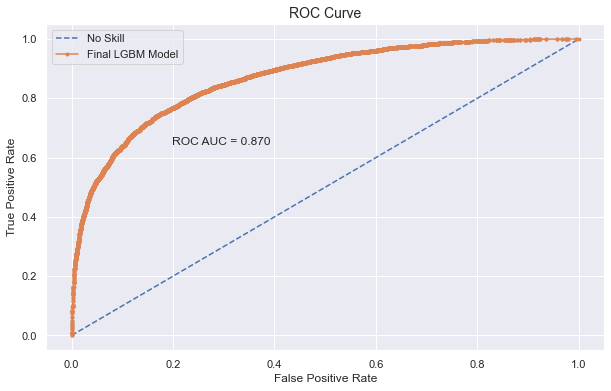

In [181]:
lgbm_tuned_proba = lgbm_model_tuned.predict_proba(X_val_m)[:,1]

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_val))]

# # calculates the roc curves
ns_fpr, ns_tpr, _ = m.roc_curve(y_val, ns_probs)
lgbm_fpr, lgbm_tpr, _ = m.roc_curve(y_val, lgbm_tuned_proba)



# # plots the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='Final LGBM Model')

# sets plot features
plt.title("ROC Curve", fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# displays the legend
plt.legend()

#display AUC
lgbm_auc = m.roc_auc_score(y_val, lgbm_tuned_proba)
plt.figtext(.3, .6, 'ROC AUC = {:.3f}'.format(lgbm_auc))

# displays the plot
plt.show()

## 9.2 - What is CCD's profit with this model?

In [162]:
five_percent_increases = round( (mean_precision-50) / 5, 0 )

team_cost = 1000

gross_income = 500*five_percent_increases

net_income = gross_income - team_cost

hours = 8

diag_per_hour = 1

In [212]:
team_cost = 1000
hours = 8
diag_per_hour = 1

min_precision = mean_precision - std_precision
max_precision = mean_precision + std_precision

min_five_percent_increases = np.floor( (min_precision-50) / 5 )
min_gross_income = 500*min_five_percent_increases
min_net_income = min_gross_income - team_cost

max_five_percent_increases = np.floor( (max_precision-50) / 5 )
max_gross_income = 500*max_five_percent_increases
max_net_income = max_gross_income - team_cost

print('Assuming that the specialists team is still charging ${} to carefully review each diagnosys, the profit per diagnosys will be: '.format(team_cost, hours*diag_per_hour, diag_per_hour, hours))
print('Worst case scenario ({:.2f}% precision): '.format(min_precision) + '\033[1m' +'${:.2f}'.format(min_net_income) +'\033[0m' + '.' )
print('Best case scenario ({:.2f}% precision): '.format(max_precision) + '\033[1m' +'${:.2f}'.format(max_net_income) +'\033[0m' + '.' )

Assuming that the specialists team is still charging $1000 to carefully review each diagnosys, the profit per diagnosys will be: 
Worst case scenario (73.53% precision): $1000.00.
Best case scenario (75.38% precision): $1500.00.


In [213]:
working_days = 22

print('Considering {} working days per month and a total of {} diagnosys being made each day ({} diagnosys/hour on an {} hour journey),\
CDD´s monthly profit will be:'.format(working_days,  hours*diag_per_hour, diag_per_hour, hours) )

print('Worst case scenario ({:.2f}% precision): '.format(min_precision) + '\033[1m' +'${:.2f}'.format(min_net_income*working_days*hours*diag_per_hour) +'\033[0m' + '.' )
print('Best case scenario ({:.2f}% precision): '.format(max_precision) + '\033[1m' +'${:.2f}'.format(max_net_income*working_days*hours*diag_per_hour) +'\033[0m' + '.' )

Considering 22 working days per month and a total of 8 diagnosys being made each day (1 diagnosys/hour on an 8 hour journey),CDD´s monthly profit will be:
Worst case scenario (73.53% precision): $176000.00.
Best case scenario (75.38% precision): $264000.00.


## 9.3 - What is the confidence level of the model?

In [165]:
std_precision =  lgbm_tuned_cv['std precision'].values[0]*100
z = {80:1.28, 90:1.645, 95: 1.96, 98: 2.33, 99: 2.58}
sample_size = k_folds

In [166]:
perc = 99 

ci = z[perc]*std_precision/sqrt(sample_size)
ci_max = mean_precision + ci
ci_min = mean_precision - ci

In [167]:
ci

0.7558867711349023

In [168]:
print( 'The confidence interval is ' + '\033[1m' + '{:.2f}% '.format(ci) + '\033[0m' + \
      'for a ' + '\033[1m' + '{}% '.format(perc) + '\033[0m' + 'confidence level, which means that with '\
      + '\033[1m' + '{}% '.format(perc) + '\033[0m' +  'confidence the precision of the diagnosys is within ' + '\033[1m' + '{:.2f}% '.format(ci_min) + '\033[0m' +\
     'and ' + '\033[1m' + '{:.2f}% '.format(ci_max) + '\033[0m'+'.')

The confidence interval is 0.76% for a 99% confidence level, which means that with 99% confidence the precision of the diagnosys is within 73.70% and 75.21% .


# 10.0 STEP 10 - MODEL DEPLOYMENT INTO PRODUCTION

## 10.1 CDD Class

In [169]:
import pickle
import pandas as pd
import numpy as np

from sklearn import preprocessing as pp

class cdd( object ):
    def __init__( self ):
        self.annual_premium_scaler   = pickle.load( open( 'parameters/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler              = pickle.load( open( 'parameters/age_scaler.pkl', 'rb' ) )
        self.vintage_scaler          = pickle.load( open( 'parameters/vintage_scaler.pkl', 'rb' ) )
     
       
    def data_preparation( self, df1 ):
        
        #column renaming
        cols_new = [ 'id', 'age', 'gender', 'height', 'weight', 'sbp', 'dbp', 'cholesterol', 'glucose', 'smoking', 'alcohol', 'active', 'cardio']

        df1.columns = cols_new
        
        #converting initial data 
        df1['age_years'] = df1['age'].apply( lambda x: round(x/365,1) )
        df1['cholesterol'] = df1['cholesterol'].apply(lambda x: 'Normal' if x == 1 else 'Above normal' if x== 2 else 'Well above normal')
        
        #feature engineering
        #BMI   
        df1['bmi'] = df1.apply(lambda x: round(x['weight']/(x['height']/100)**2, 2), axis = 1)

        #standardization
        ss = pp.StandardScaler()
        #height
        df1['height'] = ss.fit_transform( df1[['height']].values )
        #weight
        df1['weight'] = ss.fit_transform( df1[['weight']].values )
        #BMI
        df1['bmi'] = ss.fit_transform( df1[['bmi']].values )
        #SBP
        df1['sbp'] = ss.fit_transform( df1[['sbp']].values )
        #DBP
        df1['dbp'] = ss.fit_transform( df1[['dbp']].values )
       
        #reescaling
        mms_age = pp.MinMaxScaler()
        #age
        df1['age'] = mms_age.fit_transform( df1[['age_years']].values )
        
        #encoding
        #cholesterol
        df1 = pd.get_dummies( df1, prefix = ['cholesterol'], columns = ['cholesterol'] )
        #glucose
        df1 = pd.get_dummies( df1, prefix = ['glucose'], columns = ['glucose'] )
        #smoking
        a_dict = {'Yes': 1, 'No': 0}
        df1['smoking'] = df1['smoking'].map(a_dict)
        #alcohol
        df1['alcohol'] = df1['alcohol'].map(a_dict)
        #active
        df1['active'] = df1['active'].map(a_dict)
        #gender
        g_dict = {'Male': 0, 'Female': 1}
        df1['gender'] = df1['gender'].map(g_dict)
        
        #column renaming after preparation
        # rename
        cols_old = list(df15.columns)
        cols_new = [x.lower() for x in cols_old]
        cols_new = [x.replace(" ", "_") for x in cols_new]
        df1.columns = cols_new

        cols_selected_importance = \
        ['age', 'sbp', 'bmi', 'weight', 'height', 'dbp', 'cholesterol_normal', 'cholesterol_above_normal', 'cholesterol_well_above_normal']
        
        return df1[ cols_selected_importance ]
        
    
    def get_prediction( self, model, original_data, test_data):
        
        #prediction
        pred = model.predict( test_data )
        
        #merging prediction into original dataset
        original_data['cardio'] = pred[:,1].tolist()
        #original_data = original_data.sort_values(by = 'score', ascending = False)
        #original_data = original_data.reset_index()
        
        return original_data.to_json( orient = 'records', date_format = 'iso')
        

## 10.2 API Handler

In [170]:
import os
import pickle

import pandas     as pd

from flask import Flask, request, Response

from cdd.Cdd import cdd

#loading model
model = pickle.load( open( 'model/lgbm.pkl', 'rb' ) )


#API intialization
app = Flask( __name__ )

@app.route( '/cdd/predict', methods = ['POST'] )

def cdd_predict():
	test_json = request.get_json()
    
	if test_json: # there is data
		if isinstance( test_json, dict ): #single example
			test_raw = pd.DataFrame( test_json, index = [0] )
            
		else:  #multiple example      
			test_raw = pd.DataFrame( test_json, columns = test_json[0].keys() )
            
		# instantiate insurance class
		pipeline = Insurance()
        
		#data preparation
		df3 = pipeline.data_preparation( test_raw )
        
		#prediction
		df_response = pipeline.get_prediction( model, test_raw, df3 )
        
		return df_response
            
	else: # no data
		return Response( '{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
	port = os.environ.get( 'PORT', 5000)
	app.run(host = '0.0.0.0', port = port )

ModuleNotFoundError: No module named 'cdd'

## 10.3 API Tester

In [ ]:
import json
import requests

In [ ]:
#carregar dataset de teste
#df_test = pd.read_csv( 'data/cardio_train.csv' )
df_test = df_raw

In [ ]:
#X = df_raw.drop('response', axis = 1)
#y = df_raw['response']
#X_train1, X_val1, y_train1, y_val1 = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
df_test.head()

In [ ]:
data = json.dumps( df_test.to_dict( orient = 'records' ) )

In [ ]:
url = 'http://localhost:5000/cdd/predict'
#url = 'https://fresmini-insurance.herokuapp.com/insurance/predict'

header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers = header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
cardio_df = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

In [ ]:
cardio_df.head()